In [1]:
%load_ext cython
import speckle_tracking as st
import st_sim
from st_sim.bin import *
import h5py
import os
import numpy as np
import pickle
import concurrent.futures
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, convolve1d
from scipy.integrate import quad
from scipy.optimize import least_squares
from scipy.special import erf

In [2]:
def inv_geomspace(x0, x1, n):
    y = np.linspace(x0, x1, n)
    return (x1 - x0) / (np.log(x1) - np.log(x0)) * (np.log(y) - np.log(x0)) + x0

def ab_model(pix, coeff):
    return coeff[0] * (pix - coeff[2])**2 + coeff[1]

def ab_errors(coeff, data):
    return ab_model(data[:, 0], coeff) - data[:, 1]

def ph_model(theta, coeff):
    return coeff[0] * (theta - coeff[3])**3 + coeff[1] * (theta - coeff[3]) + coeff[2]

def ph_errors(coeff, data):
    return ph_model(data[:, 0], coeff) - data[:, 1]

def snr_exp(ppix, attenuation, bar_size, bar_sigma):
    sigma_s = attenuation / 2 * np.sqrt((1 - 4 * bar_sigma / bar_size * np.tanh(bar_size / 4 / bar_sigma)))
    return sigma_s * np.sqrt(ppix)

def speckle_tracking(cxi_path, max_iter=5, search_window=(1, 200), phase_roi=(20,-20)):
    with h5py.File(cxi_path, 'r') as cxi_file:
        roi_st = cxi_file['/speckle_tracking/roi'][...]
        data_st = cxi_file['/entry_1/data_1/data'][:, :, roi_st[2]:roi_st[3]].sum(axis=1)[:, None]
        mask_st = cxi_file['/speckle_tracking/mask'][roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
        w_st = cxi_file['/speckle_tracking/whitefield'][roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
        basis_st = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
        z_st = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
        x_ps_st = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
        y_ps_st = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
        wl_st = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
        dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
        df_st = cxi_file['/speckle_tracking/defocus'][...]
    data_st = np.ascontiguousarray(data_st)
    ppix = np.mean(data_st[..., 30:-30])
    sigma = np.std(data_st[..., 30:-30])
    

    # generate pixel map
    u_st, dij_pix, _ = st.generate_pixel_map(w_st.shape, dij, basis_st,
                                             x_ps_st, y_ps_st, z_st, df_st, verbose=False)

    # make reference image
    O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st, subpixel=True)

    errors = []
    for i in range(max_iter):

        # calculate errors
        error_total = st.calc_error(data_st, mask_st, w_st, dij_pix, O, u_st,
                                    n0, m0, subpixel=True, verbose=False)[0]

        # store total error
        errors.append(error_total / data_st.size)

        # update pixel map
        u_st = st.update_pixel_map(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix,
                                   search_window=search_window, subpixel=True,
                                   fill_bad_pix=True, integrate=False,
                                   quadratic_refinement=True, verbose=False)[0]

        # make reference image
        O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st,
                                       subpixel=True, verbose=False)
        # update translations
        dij_pix = st.update_translations(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix)[0]

    # calculate phase
    ur_st = np.array([phase_roi[0], data_st.shape[-1] + phase_roi[1]])
    u_pix = (u_st[1, 0] - np.arange(roi_st[3] - roi_st[2]))[ur_st[0]:ur_st[1]]
    u = u_pix * x_ps_st / z_st
    ph_st = np.cumsum(u) * x_ps_st * df_st / z_st * 2 * np.pi / wl_st
    pix_st = np.arange(roi_st[3] - roi_st[2])[ur_st[0]:ur_st[1]]
    x_st, th_st = pix_st * x_ps_st, pix_st * x_ps_st / z_st

    # fit model to phase
    fit_data = np.stack((pix_st, gaussian_filter(u_pix, 10)), axis=-1)
    pix0 = pix_st[np.argmin(fit_data[:, 1])]
    res_u = least_squares(ab_errors, np.array([0, 0, pix0]), args=(fit_data,), xtol=1e-14, ftol=1e-14,
                          bounds=([-np.inf, -np.inf, pix0 - 200], [np.inf, np.inf, pix0 + 200]), loss='cauchy')
    fit_u = np.array([res_u.x[0] * z_st / x_ps_st,
                      res_u.x[1] * x_ps_st / z_st,
                      res_u.x[2] * x_ps_st / z_st])
    idx0 = np.searchsorted(th_st, fit_u[2])
    ph0 = 0 if idx0 == th_st.size else ph_st[np.searchsorted(th_st, fit_u[2])]
    fit_ph = np.array([fit_u[0] * 2 * np.pi / wl_st * df_st / 3,
                       fit_u[1] * 2 * np.pi / wl_st * df_st, ph0, fit_u[2]])

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(res_u.x, fit_data)**2) / np.sum((fit_data[:, 1] - fit_data[:, 1].mean())**2)
    if np.linalg.det(res_u.jac.T.dot(res_u.jac)):
        cov = np.linalg.inv(res_u.jac.T.dot(res_u.jac))
        dalpha = np.sqrt(cov[0, 0]) * z_st / x_ps_st * 2 * np.pi / wl_st * df_st / 3
    else:
        dalpha = 0

    return {'dev_angle': u, 'phase': ph_st, 'fit': res_u, 'fit_u': fit_u, 'fit_ph': fit_ph, 'pixel_map': u_pix,
            'theta': th_st, 'st_err': np.array(errors), 'r_sq':r_sq, 'dalpha': dalpha, 'ppix': ppix, 'sigma': sigma}

# dev

In [4]:
%%cython -c=-fopenmp -lgsl -lgslcblas -lomp -L=/usr/local/lib
#cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
cimport numpy as cnp
import numpy as np
cimport openmp
from cython_gsl cimport *
from libc.math cimport sqrt, cos, sin, exp, pi, tanh
from cython.parallel import prange, parallel

ctypedef cnp.complex128_t complex_t
ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint64_t uint_t
ctypedef cnp.uint8_t uint8_t

cdef complex_t fhf_wp(complex_t[::1] wf0, float_t[::1] x_arr, float_t xx, float_t dist, float_t wl) nogil:
    cdef:
        int_t a = wf0.shape[0], i
        float_t ph0, ph1, ph = pi / wl / dist * xx**2
        complex_t wf = 0 + 0j
    ph0 = 2 * pi / wl / dist * x_arr[0] * xx
    ph1 = 2 * pi / wl / dist * x_arr[1] * xx
    wf = (wf0[0] * (cos(ph0) - 1j * sin(ph0)) + wf0[1] * (cos(ph1) - 1j * sin(ph1))) / 2 * (x_arr[1] - x_arr[0])
    for i in range(2, a):
        ph0 = ph1
        ph1 = 2 * pi / wl / dist * x_arr[i] * xx
        wf += (wf0[i - 1] * (cos(ph0) - 1j * sin(ph0)) + wf0[i] * (cos(ph1) - 1j * sin(ph1))) / 2 * (x_arr[i] - x_arr[i - 1])
    return wf * (cos(ph) + 1j * sin(ph))

cdef void fhf_1d(complex_t[::1] wf1, complex_t[::1] wf0, float_t[::1] x_arr, float_t[::1] xx_arr, float_t dist, float_t wl) nogil:
    cdef:
        int_t a = xx_arr.shape[0], i
    for i in range(a):
        wf1[i] = fhf_wp(wf0, x_arr, xx_arr[i], dist, wl)

def fraunhofer_2d_serial(complex_t[:, ::1] wf0, float_t[::1] x_arr, float_t[::1] xx_arr, float_t dist, float_t wl):
    """
    1D Fraunhofer diffraction calculation for an array of wavefronts (without the coefficient)

    wf0 - an array of wavefronts at the plane downstream
    x_arr - coordinates at the plane downstream [um]
    xx_arr - coordinates at the plane upstream [um]
    dist - distance between planes [um]
    wl - wavelength [um]
    """
    cdef:
        int_t a = wf0.shape[0], b = xx_arr.shape[0], i
        complex_t[:, ::1] wf = np.empty((a, b), dtype=np.complex128)
    for i in range(a):
        fhf_1d(wf[i], wf0[i], x_arr, xx_arr, dist, wl)
    return np.asarray(wf)

cdef void bc_1d(float_t[::1] bc_t, float_t[::1] x_arr, float_t[::1] bsteps,
                float_t b_sigma, float_t atn, float_t step) nogil:
    cdef:
        int_t a = x_arr.shape[0], aa = bsteps.shape[0], i, ii
        float_t tr, bs_x0, bs_x1, t
    for i in range(a):
        tr = 0
        for ii in range(aa / 2):
            bs_x0 = ((x_arr[i] - x_arr[0]) - bsteps[2 * ii] + step) / 2 / b_sigma
            bs_x1 = -((x_arr[i] - x_arr[0]) - bsteps[2 * ii + 1] + step) / 2 / b_sigma
            tr += 0.5 * erf(bs_x0) * erf(bs_x1) + 0.5
        bc_t[i] = sqrt(1 - atn + atn * tr)

def barcode(float_t[::1] x_arr, float_t[::1] bsteps, float_t b_sigma, float_t atn, float_t step_size, int_t n_frames):
    """
    Barcode transmission array for a scan

    x_arr - coordinates [um]
    bsteps - bar coordinates array [um]
    b_sigma - bar haziness width [um]
    atn - bar attenuation (0.0 - 1.0)
    step_size - scan step size [um]
    n_frames - number of frames of a scan
    """
    cdef:
        int_t a = x_arr.shape[0], i
        float_t[:, ::1] bc_t = np.empty((n_frames, a), dtype=np.float64)
    for i in prange(n_frames, schedule='guided', nogil=True):
        bc_1d(bc_t[i], x_arr, bsteps, b_sigma, atn, i * step_size)
    return np.asarray(bc_t)

In [5]:
params = st_sim.defaults()

defoc = 400
det_dist = params['det_dist']
step_size = 1e-1
n_frames = 300

pix_size = params['pix_size']
fs_size = params['fs_size']
ss_size = params['ss_size']

p0 = params['p0']
wl = params['wl']
th_s = params['th_s']

ap_x = params['ap_x']
ap_y = params['ap_y']
focus = params['focus']
alpha = -0.01

bar_size = 0.01
bar_sigma = params['bar_sigma']
attenuation = 0.2
random_dev = params['random_dev']

In [6]:
params = st_sim.defaults()
for param in params:
    if param in globals():
        params[param] = globals()[param]
        
st_sim.STSim(**params).ptych_cxi().save('results/test')

In [7]:
n_x = int(1.6 * ap_x / focus * defoc * fs_size * pix_size / wl / det_dist)
n_y = int(1.2 * ap_y * ss_size * pix_size / wl / det_dist)
x_arr = np.linspace(-0.8 * ap_x / focus * defoc, 0.8 * ap_x / focus * defoc, n_x)
y_arr = np.linspace(-0.6 * ap_y, 0.6 * ap_y, n_y)
xx_arr = pix_size * np.arange(-fs_size // 2, fs_size // 2)
yy_arr = pix_size * np.arange(-ss_size // 2, ss_size // 2)

In [8]:
wf0_x = lens(x_arr, wl, ap_x, focus, defoc, alpha)
wf0_y = aperture(y_arr, focus + defoc, wl, ap_y)
wf1_y = fraunhofer_1d(wf0_y, y_arr, yy_arr, det_dist, wl)
print(n_x, n_y)

12876 905


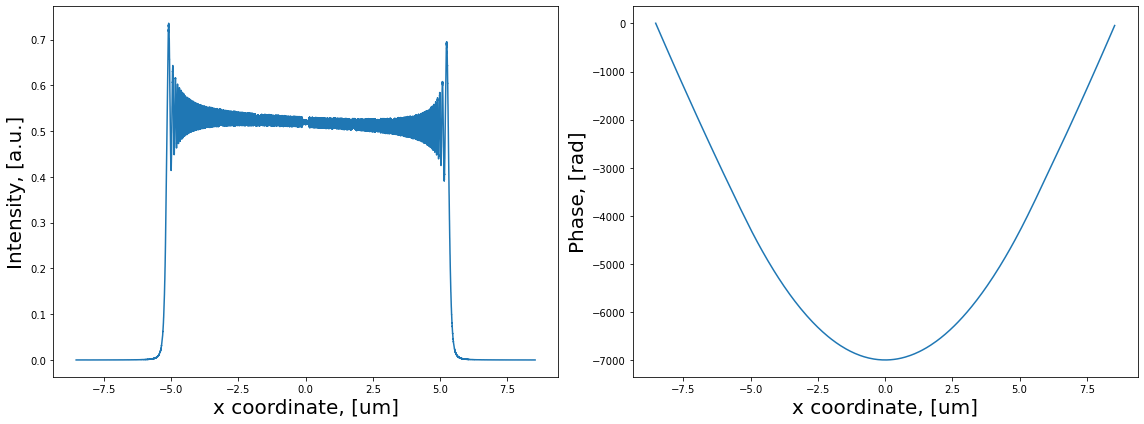

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(x_arr, np.unwrap(np.angle(wf0_x)))
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_x.pdf')

In [10]:
fx_lim = np.array([-0.45 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / defoc
print(th_lim * defoc)

[-4.74987765  5.39521278]


In [11]:
beam_span = np.clip(th_lim * defoc, x_arr[0], x_arr[-1])
wf0_roi = ((beam_span - x_arr[0]) // (x_arr[1] - x_arr[0])).astype(np.int)
xr_arr = x_arr[wf0_roi[0]:wf0_roi[1]]
wf0_ph = np.unwrap(np.angle(wf0_x))
wf0_ph_fc = np.polyfit(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], 3)
df_fit = np.pi / wl / wf0_ph_fc[1]
alpha_fit = wf0_ph_fc[0] * df_fit**3 * 1e-9
print(df_fit, alpha_fit)

399.9472456187289 -0.009929165786785028


In [12]:
wf0_ph_fit = np.pi * xr_arr**2 / wl / df_fit + alpha_fit * 1e9 * (xr_arr / df_fit)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
wf0_ph_th = np.pi * xr_arr**2 / wl / defoc + alpha * 1e9 * (xr_arr / defoc)**3 + wf0_ph[np.searchsorted(x_arr, 0)]

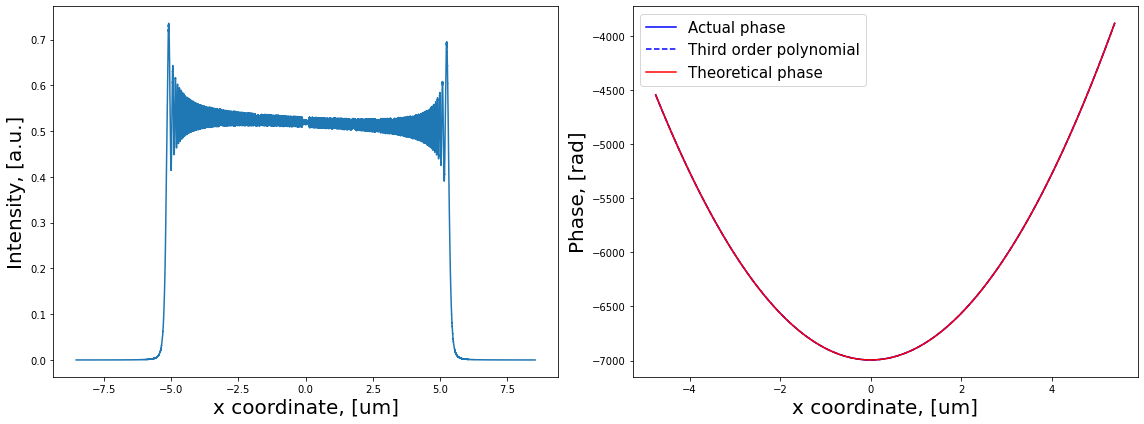

In [13]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], label='Actual phase', color='b')
axes[1].plot(xr_arr, wf0_ph_fit, color='b', label='Third order polynomial', linestyle='dashed')
axes[1].plot(xr_arr, wf0_ph_th, color='r', label='Theoretical phase')
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_phase_2.pdf')

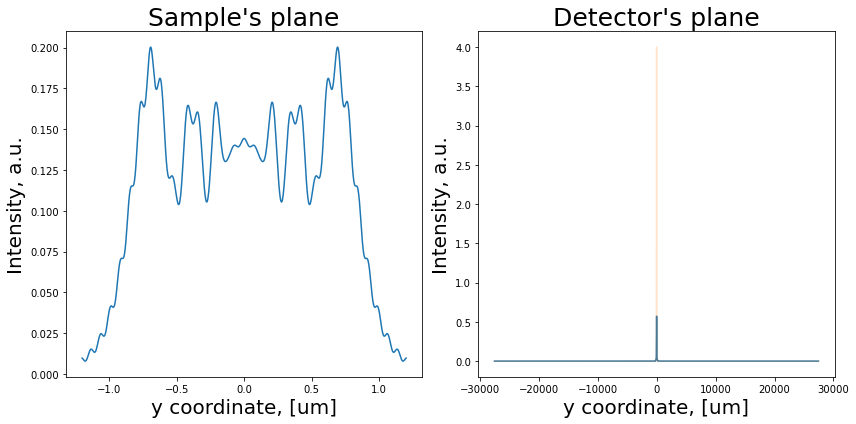

In [12]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(y_arr, np.abs(wf0_y)**2)
axes[1].plot(yy_arr, np.abs(wf1_y)**2)
axes[1].plot(yy_arr, (ap_y * np.sinc(np.pi * ap_y * yy_arr / wl / (det_dist + focus + defoc)))**2, alpha=0.2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

NameError: name 'wf1_x' is not defined

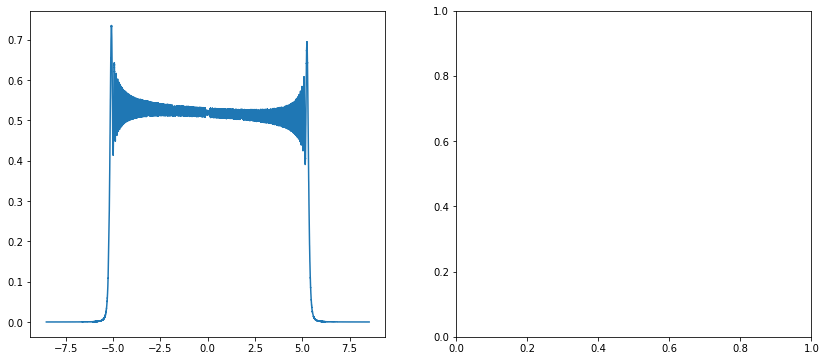

In [44]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[1].plot(xx_arr, np.abs(wf1_x[10])**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

In [59]:
def var_t(bar_size, bar_sigma, attenuation):
    br = bar_size / bar_sigma
    term1 = np.sqrt(64 / np.pi) * np.exp(-br**2 / 16) * erf(br / 4) / br
    term3 = np.sqrt(32 / np.pi) * erf(br / np.sqrt(8)) / br
    return attenuation / 2 * np.sqrt(term1 + erf(br / 4) - term3)

def var_ts(bar_size, bar_sigma, attenuation, th_s, defoc):
    return var_t(bar_size, np.sqrt(bar_sigma**2 + (th_s * defoc)**2 / 2), attenuation)

def dvar_t(bar_size, bar_sigma, attenuation):
    br = bar_size / np.sqrt(8) / bar_sigma
    return attenuation * np.sqrt(erf(br) / np.sqrt(8 * np.pi) / bar_size / bar_sigma)

def dvar_ts(bar_size, bar_sigma, attenuation, th_s, defoc):
    return dvar_t(bar_size, np.sqrt(bar_sigma**2 + (th_s * defoc)**2 / 2), attenuation)

In [15]:
attenuation = 0.3
p0 = 2e5
bar_size = 0.1
bar_sigma = 0.01
fx_lim = np.array([-0.5 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / (det_dist + defoc)
pdet = p0 * (1 - attenuation / 2) 
ppix = pdet * pix_size / (np.tan(th_lim)[1] - np.tan(th_lim)[0]) / (det_dist + defoc)
print(ppix, var_t(bar_size, bar_sigma, attenuation) * ppix,
      var_t(bar_size, bar_sigma, attenuation) * np.sqrt(ppix))

175.26705757646596 21.70021581259679 1.6391319104181516


In [16]:
bsteps = barcode_steps(x_arr[-1] - x_arr[0], bar_size, random_dev, step_size, n_frames)
bs_t = barcode(x_arr, bsteps, bar_sigma, attenuation, step_size, n_frames)
wf1_x = fraunhofer_2d(wf0_x * bs_t, x_arr, xx_arr, det_dist, wl)

In [17]:
th_s = 2e-4
i0 = p0 / ap_x / ap_y
sigma = th_s * (focus + defoc + det_dist)
sx_arr = pix_size * np.arange(-np.ceil(4 * sigma / pix_size), np.ceil(4 * sigma / pix_size) + 1)
s_arr = np.exp(-sx_arr**2 / 2 / sigma**2)
s_arr /= s_arr.sum()
print(s_arr.size, np.std(convolve1d(bs_t[0]**2, s_arr)) * np.sqrt(ppix))

61 1.53782418013575


In [18]:
dx = x_arr[1] - x_arr[0]
ssigma = th_s * defoc
ssx_arr = dx * np.arange(-np.ceil(4 * ssigma / dx), np.ceil(4 * ssigma / dx) + 1)
ss_arr = np.exp(-ssx_arr**2 / 2 / ssigma**2)
ss_arr /= ss_arr.sum()
print(ss_arr.size)

485


In [60]:
dvar_t(bar_size, bar_sigma, attenuation)

4.23702635416581

In [62]:
print(dvar_t(bar_size, bar_sigma, attenuation),
      dvar_ts(bar_size, bar_sigma, attenuation, th_s, defoc))
print(var_t(bar_size, bar_sigma, attenuation),
      var_ts(bar_size, bar_sigma, attenuation, th_s, defoc))

4.23702635416581 1.3873692028711544
0.12381229029950118 0.08527511374645043


In [63]:
print(np.std(np.gradient(bs_t[0]**2, x_arr[1] - x_arr[0])),
      np.std(convolve1d(np.gradient(bs_t[0]**2, x_arr[1] - x_arr[0]), ss_arr)))
print(np.std(bs_t[0]**2), np.std(convolve1d(bs_t[0]**2, ss_arr)))

4.289163478030831 0.38029121941112376
0.12255011241942114 0.03607641558874217


In [72]:
th_ss = np.linspace(1e-6, 1e-4, 100)
ssigma = th_ss * defoc
ssx_arr = dx * np.arange(-np.ceil(4 * ssigma.max() / dx), np.ceil(4 * ssigma.max() / dx) + 1)
ss_mat = np.exp(-ssx_arr[None, :]**2 / 2 / ssigma[:, None]**2)
ss_mat = ss_mat / ss_mat.sum(axis=1)[:, None]
bs_ts = np.array([convolve1d(bs_t[0]**2, ss_arr) for ss_arr in ss_mat])
var_ts_exp = np.std(bs_ts, axis=1)
dvar_ts_exp = np.std(np.gradient(bs_ts, dx, axis=1), axis=1)

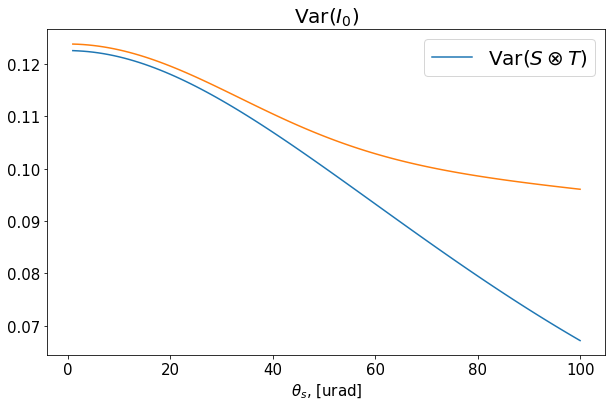

In [75]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(th_ss * 1e6, var_ts_exp, label=r'$\mathrm{Var}(S \otimes T)$')
ax.plot(th_ss * 1e6, var_ts(bar_size, bar_sigma, attenuation, th_ss, defoc))
ax.set_title(r'$\mathrm{Var}(I_0)$', fontsize=20)
ax.set_xlabel(r'$\theta_s$, [urad]', fontsize=15)
ax.legend(fontsize=20)
ax.tick_params(labelsize=15)
plt.show()
# plt.savefig('figures/var_t.pdf')

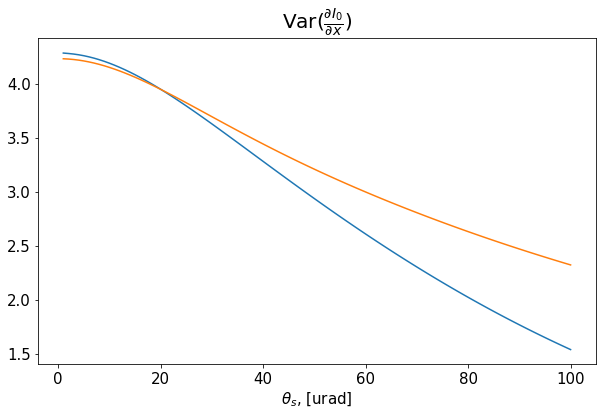

In [77]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(th_ss * 1e6, dvar_ts_exp)
ax.plot(th_ss * 1e6, dvar_ts(bar_size, bar_sigma, attenuation, th_ss, defoc))
ax.set_title(r'$\mathrm{Var}(\frac{\partial I_0}{\partial x})$', fontsize=20)
ax.set_xlabel(r'$\theta_s$, [urad]', fontsize=15)
ax.tick_params(labelsize=15)
plt.show()
# plt.savefig('figures/var_t.pdf')

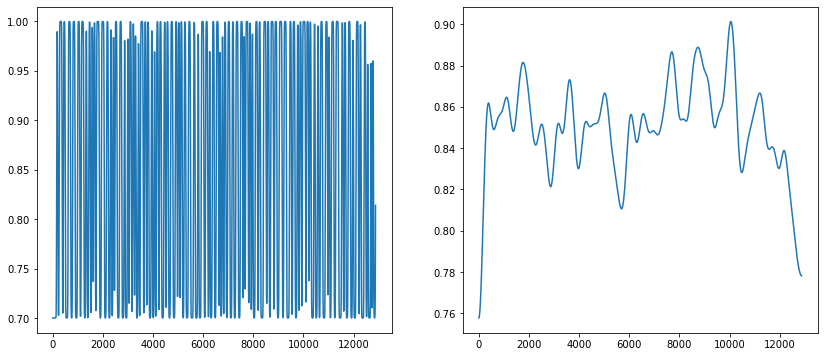

In [35]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(bs_t[0]**2)
axes[1].plot(convolve1d(bs_t[0]**2, ss_arr))
plt.show()

In [158]:
det_c = 1 / wl**2 / (focus + defoc) / det_dist
data = make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                   sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size)
# data = make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=np.abs(wf1_y)**2,
#                    sc_x=s_arr,  sc_y=s_arr, pix_size=pix_size)
beam_span = np.tan(th_lim) * (det_dist + defoc)
x_roi = np.clip((beam_span - xx_arr.min()) // pix_size, 0, fs_size).astype(np.int)
roi = (data.shape[1] // 2, data.shape[1] // 2 + 1, x_roi[0], x_roi[1])
ptych = data[:, :, roi[2]:roi[3]].sum(axis=1)
mask = np.ones((data.shape[1], data.shape[2]), dtype=np.uint8)
whitefield = make_whitefield(data, mask)
print(data.shape, np.mean(ptych[..., 20:-20]), np.std(ptych[..., 20:-20]),
      np.std(ptych[..., 20:-20]) / np.sqrt(np.mean(ptych[..., 20:-20])))

(300, 1, 2000) 172.56294223179046 16.130871176295564 1.227959531230418


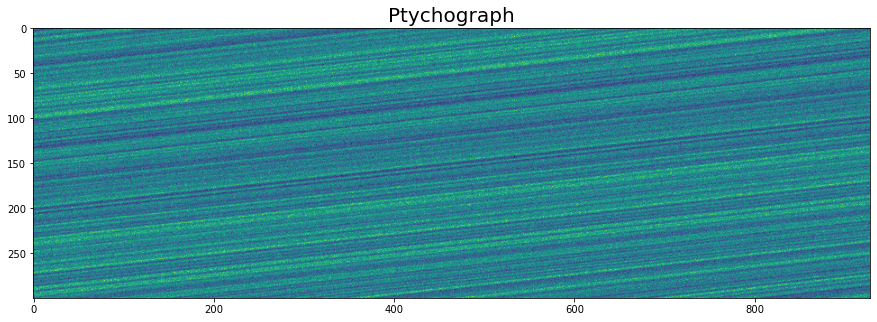

In [143]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(ptych[..., 20:-20])
ax.set_title('Ptychograph', fontsize=20)
plt.show()

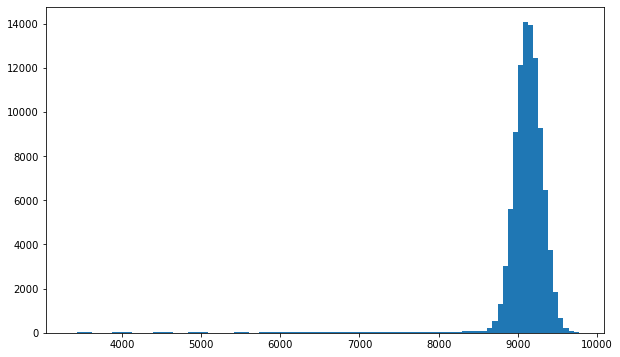

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ptych.ravel(), min(int(ptych.max() - ptych.min()), 100))
plt.show()

In [17]:
params = st_sim.defaults()
for param in params:
    if param in globals():
        params[param] = globals()[param]     
ini_parser = st_sim.STSim.export_ini(**params)
with open('results/test/parameters.ini', 'w') as file:
    ini_parser.write(file)

with h5py.File('results/test/data.cxi', 'r+') as cxi_file:
    cxi_file['/entry_1/data_1/data'][...] = data.astype(np.float32)
    cxi_file['/speckle_tracking/whitefield'][...] = whitefield.astype(np.float32)
    cxi_file['/speckle_tracking/mask'][...] = mask.astype(bool)
    cxi_file['/entry_1/instrument_1/detector_1/distance'][...] = det_dist * 1e-6
    cxi_file['/speckle_tracking/defocus'][...] = defoc * 1e-6
    cxi_file['/speckle_tracking/roi'][...] = np.array(roi)

TypeError: Can't broadcast (100, 1, 2000) -> (300, 1, 2000)

# st_sim

In [727]:
set(st_sim.STConverter.defaults) == set(st_sim.STConverter.attr_set)

True

In [ ]:
class STLoader():

    defaults = {'data_path': '/entry_1/data_1/data',
                'whitefield_path': '/speckle_tracking/whitefield',
                'mask_path': '/speckle_tracking/mask',
                'roi_path': '/speckle_tracking/roi',
                'defocus_path': '/speckle_tracking/defocus',
                'translations_path': '/entry_1/sample_1/geometry/translations',
                'good_frames_path': '/frame_selector/good_frames',
                'y_pixel_size_path': '/entry_1/instrument_1/detector_1/y_pixel_size',
                'x_pixel_size_path': '/entry_1/instrument_1/detector_1/x_pixel_size',
                'distance_path': '/entry_1/instrument_1/detector_1/distance',
                'energy_path': '/entry_1/instrument_1/source_1/energy',
                'wavelength_path': '/entry_1/instrument_1/source_1/wavelength',
                'basis_vectors_path': '/entry_1/instrument_1/detector_1/basis_vectors'}
    
    def __init__(self, **kwargs):
        for attr in self.defaults:
            if attr in kwargs:
                self.__dict__[attr] = kwargs[attr]
            else:
                self.__dict__[attr] = self.defaults[attr]
            
                
    def load(self, cxi_path, roi=None):
        data_dict = {}
        with h5py.File(cxi_path, 'r') as cxi_file:
            if roi:
                data_dict['roi'] = roi
            elif self.roi_path in cxi_file:
                data_dict['roi'] = cxi_file[self.roi_path][...]
            else:
                

In [ ]:
def speckle_tracking(cxi_path, max_iter=5, search_window=(1, 200), phase_roi=(20,-20)):
    with h5py.File(cxi_path, 'r') as cxi_file:
        roi_st = cxi_file['/speckle_tracking/roi'][...]
        data_st = cxi_file['/entry_1/data_1/data'][:, :, roi_st[2]:roi_st[3]].sum(axis=1)[:, None]
        mask_st = cxi_file['/speckle_tracking/mask'][roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
        w_st = cxi_file['/speckle_tracking/whitefield'][roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
        basis_st = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
        z_st = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
        x_ps_st = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
        y_ps_st = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
        wl_st = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
        dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
        df_st = cxi_file['/speckle_tracking/defocus'][...]
    data_st = np.ascontiguousarray(data_st)
    ppix = np.mean(data_st[..., 30:-30])
    sigma = np.std(data_st[..., 30:-30])
    

    # generate pixel map
    u_st, dij_pix, _ = st.generate_pixel_map(w_st.shape, dij, basis_st,
                                             x_ps_st, y_ps_st, z_st, df_st, verbose=False)

    # make reference image
    O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st, subpixel=True)

    errors = []
    for i in range(max_iter):

        # calculate errors
        error_total = st.calc_error(data_st, mask_st, w_st, dij_pix, O, u_st,
                                    n0, m0, subpixel=True, verbose=False)[0]

        # store total error
        errors.append(error_total / data_st.size)

        # update pixel map
        u_st = st.update_pixel_map(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix,
                                   search_window=search_window, subpixel=True,
                                   fill_bad_pix=True, integrate=False,
                                   quadratic_refinement=True, verbose=False)[0]

        # make reference image
        O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st,
                                       subpixel=True, verbose=False)
        # update translations
        dij_pix = st.update_translations(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix)[0]

    # calculate phase
    ur_st = np.array([phase_roi[0], data_st.shape[-1] + phase_roi[1]])
    u_pix = (u_st[1, 0] - np.arange(roi_st[3] - roi_st[2]))[ur_st[0]:ur_st[1]]
    u = u_pix * x_ps_st / z_st
    ph_st = np.cumsum(u) * x_ps_st * df_st / z_st * 2 * np.pi / wl_st
    pix_st = np.arange(roi_st[3] - roi_st[2])[ur_st[0]:ur_st[1]]
    x_st, th_st = pix_st * x_ps_st, pix_st * x_ps_st / z_st

    # fit model to phase
    fit_data = np.stack((pix_st, gaussian_filter(u_pix, 10)), axis=-1)
    pix0 = pix_st[np.argmin(fit_data[:, 1])]
    res_u = least_squares(ab_errors, np.array([0, 0, pix0]), args=(fit_data,), xtol=1e-14, ftol=1e-14,
                          bounds=([-np.inf, -np.inf, pix0 - 200], [np.inf, np.inf, pix0 + 200]), loss='cauchy')
    fit_u = np.array([res_u.x[0] * z_st / x_ps_st,
                      res_u.x[1] * x_ps_st / z_st,
                      res_u.x[2] * x_ps_st / z_st])
    idx0 = np.searchsorted(th_st, fit_u[2])
    ph0 = 0 if idx0 == th_st.size else ph_st[np.searchsorted(th_st, fit_u[2])]
    fit_ph = np.array([fit_u[0] * 2 * np.pi / wl_st * df_st / 3,
                       fit_u[1] * 2 * np.pi / wl_st * df_st, ph0, fit_u[2]])

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(res_u.x, fit_data)**2) / np.sum((fit_data[:, 1] - fit_data[:, 1].mean())**2)
    if np.linalg.det(res_u.jac.T.dot(res_u.jac)):
        cov = np.linalg.inv(res_u.jac.T.dot(res_u.jac))
        dalpha = np.sqrt(cov[0, 0]) * z_st / x_ps_st * 2 * np.pi / wl_st * df_st / 3
    else:
        dalpha = 0

    return {'dev_angle': u, 'phase': ph_st, 'fit': res_u, 'fit_u': fit_u, 'fit_ph': fit_ph, 'pixel_map': u_pix,
            'theta': th_st, 'st_err': np.array(errors), 'r_sq':r_sq, 'dalpha': dalpha, 'ppix': ppix, 'sigma': sigma}

In [29]:
data_dir = 'results/test'

In [730]:
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi_st = cxi_file['/speckle_tracking/roi'][...]
    data_st = cxi_file['/entry_1/data_1/data'][:, :, roi_st[2]:roi_st[3]].sum(axis=1)[:, None]
    mask_st = cxi_file['/speckle_tracking/mask'][roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
    w_st = cxi_file['/speckle_tracking/whitefield'][roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
    basis_st = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z_st = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps_st = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps_st = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl_st = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df_st = cxi_file['/speckle_tracking/defocus'][...]

False


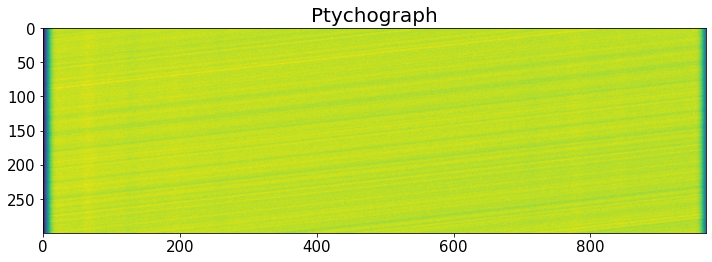

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(data_st[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.show()
# plt.savefig('figures/ptycho.pdf')

In [20]:
params = st_sim.STSim.import_ini(os.path.join(data_dir, 'parameters.ini'))

fx = params['ap_x'] / 2 / params['focus']
z_bar = params['defoc'] * params['det_dist'] / (params['defoc'] + params['det_dist'])
th_max = abs(params['wl'] / 2 / np.pi * params['alpha'] * 3e9 * fx**2 / (params['defoc'] + z_bar))
sw_max = max(int(2 * th_max / params['pix_size'] * params['det_dist']), 10)
print(sw_max, th_max)

10 7.735703649947973e-05


In [22]:
dij_pix.shape, u_st.shape,

((300, 2), (2, 1, 969))

In [21]:
#---------------------------
# Intialise
#---------------------------
data_st = np.ascontiguousarray(data_st)

# generate pixel map
u_st, dij_pix, res = st.generate_pixel_map(w_st.shape, dij, basis_st,
                                           x_ps_st, y_ps_st, z_st,
                                           df_st, verbose=False)
dss, dfs = res['dss'], res['dfs']

# make reference image
O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st, subpixel=True)

building object map: 100%|██████████| 300/300 [00:00<00:00, 3174.71it/s]


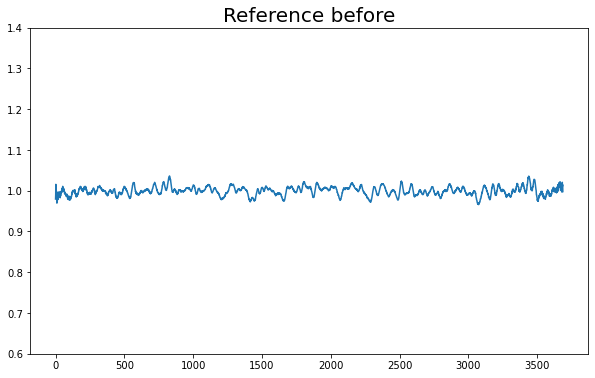

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(O[0])
ax.set_ylim(0.6, 1.4)
ax.set_title('Reference before', fontsize=20)
plt.show()

In [9]:
#---------------------------
# Main loop
#---------------------------
es = []
for i in range(10):

    # calculate errors
    error_total = st.calc_error(data_st, mask_st, w_st, dij_pix, O, u_st,
                                n0, m0, subpixel=True, verbose=False)[0]

    # store total error
    es.append(error_total)

    # update pixel map
    u_st = st.update_pixel_map(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix,
                               search_window=[1, sw_max], subpixel=True,
                               fill_bad_pix=True, integrate=False,
                               quadratic_refinement=True, verbose=False)[0]

    # make reference image
    O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st,
                                   subpixel=True, verbose=False)
    
    # update translations
    dij_pix = st.update_translations(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix)[0]

updating object map and translations: 1.37e+02:   1%|          | 1/100 [00:00<00:35,  2.82it/s]


In [11]:
ur_st = np.array([50, data_st.shape[-1] - 50])
u_pix = (u_st[1, 0] - np.arange(roi_st[3] - roi_st[2]))[ur_st[0]:ur_st[1]]
u = u_pix * x_ps_st / z_st
ph_st = np.cumsum(u) * x_ps_st * df_st / z_st * 2 * np.pi / wl_st
# pix_st = u_st[1, 0] - u_st[1, 0].min()
# pix_st = gaussian_filter(u_st[1, 0], 5)
pix_st = np.arange(roi_st[3] - roi_st[2])[ur_st[0]:ur_st[1]]
x_st, th_st = pix_st * x_ps_st, pix_st * x_ps_st / z_st

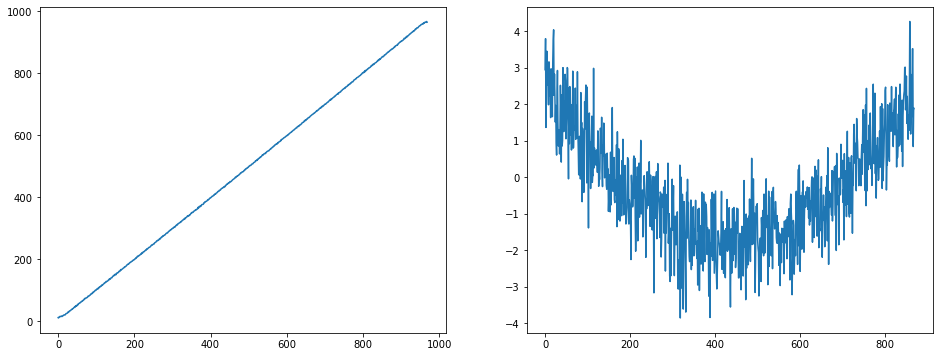

In [19]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(pix_st)
axes[1].plot(u_pix)
plt.show()

In [122]:
fit_data = np.stack((pix_st, gaussian_filter(u_pix, 10)), axis=1)
pix0 = pix_st[np.argmin(fit_data[:, 1])]
res_u = least_squares(ab_errors, np.array([0, 0, pix0]), args=(fit_data,), xtol=1e-14, ftol=1e-14,
                      bounds=([-np.inf, -np.inf, pix0 - 200], [np.inf, np.inf, pix0 + 200]), loss='cauchy')
fit_u = np.array([res_u.x[0] * z_st / x_ps_st,
                  res_u.x[1] * x_ps_st / z_st,
                  res_u.x[2] * x_ps_st / z_st])
fit_ph = np.array([fit_u[0] * 2 * np.pi / wl_st * df_st / 3,
                   fit_u[1] * 2 * np.pi / wl_st * df_st,
                   ph_st[np.searchsorted(th_st, fit_u[2])], fit_u[2]])

In [123]:
r_sq = 1 - np.sum(ab_errors(res_u.x, fit_data)**2) / np.sum((fit_data[:, 1] - fit_data[:, 1].mean())**2)
r_sq, -fit_ph[0] * 1e-9

(0.9703046968601463, -0.007139643582652986)

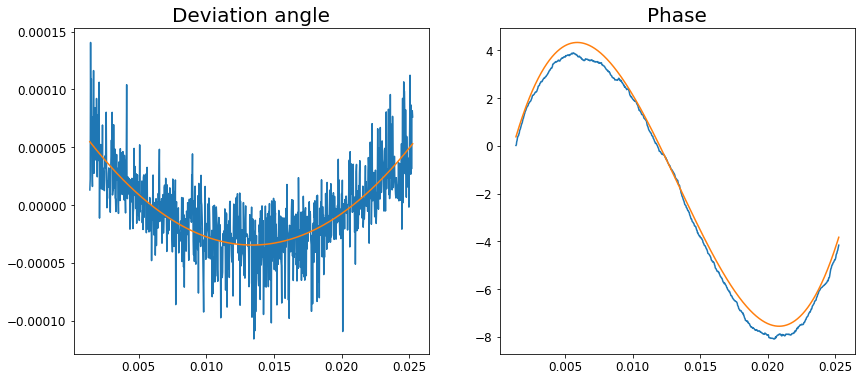

In [124]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(th_st, u)
axes[0].plot(th_st, ab_model(th_st, fit_u))
axes[0].set_title('Deviation angle', fontsize=20)
axes[1].plot(th_st, ph_st)
axes[1].plot(th_st, ph_model(th_st, fit_ph))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
# plt.show()
plt.savefig('figures/st_results.pdf')

In [269]:
#---------------------------
# Additional analysis
#---------------------------

# calcuate phase profile
ph_st = st.calculate_phase(u_st, w_st, wl_st, z_st, x_ps_st, y_ps_st,
                           dss, dfs, remove_astigmatism=False)[0][0]

cgls err: 1.46e-11:  54%|█████▎    | 1609/3000 [00:02<00:02, 670.14it/s]


In [919]:
def flip(switch):
    return -1 if switch else 1

def analyze(data, roi, det_dist=z_st, db=0, pix_size=x_ps_st, lb=None, ub=None):
    p = data[roi[0]: roi[1]]
    th_min, th_max = pix_size * (db - roi[1]) / det_dist, pix_size * (db - roi[0]) / det_dist
    x = np.linspace(th_min, th_max, p.shape[0])
    if not lb:
        lb = 0
    if not ub:
        ub = p.shape[0]
    fit = np.polyfit(x=x[lb:ub], y=p[lb:ub], deg=3)
    return fit

In [920]:
fit = analyze(ph_st, (0, ph_st.size))
fit[0] * 1e-9

0.05034840331921316

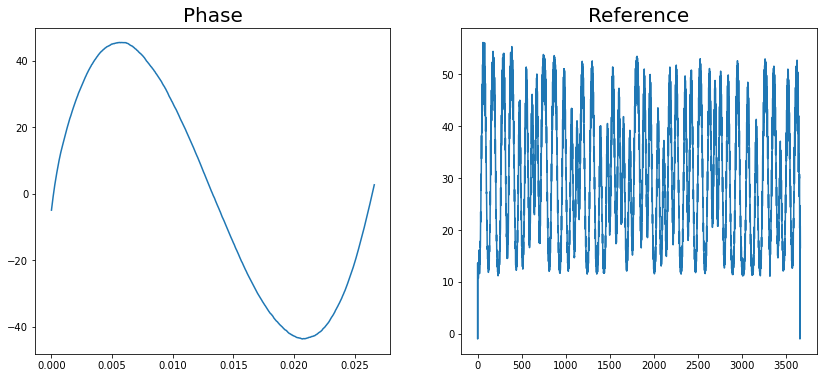

In [921]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(np.arange(ph_st.size) * x_ps_st / z_st, ph_st)
axes[0].set_title('Phase', fontsize=20)
axes[1].plot(O[0])
axes[1].set_title('Reference', fontsize=20)
plt.show()

# Experiment results

In [731]:
u_dict, o_dict, ph_dict, th_dict = {}, {}, {}, {}
uf_dict, phf_dict, data_dict, r_dict = {}, {}, {}, {}

In [754]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230)}
fname_dict = {1511: 'Scan_1511.cxi', 1512: 'Scan_1512.cxi', 1513: 'Scan_1513.cxi'}
exp_dir = 'results/exp'
key = 1513

with h5py.File(os.path.join(exp_dir, fname_dict[key]), 'r') as cxi_file:
    roi_st = roi_dict[key]
    data_st = cxi_file['/entry_1/data_1/data'][:, roi_st[0]:roi_st[1], roi_st[2]:roi_st[3]]
    basis_st = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z_st = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps_st = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps_st = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl_st = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]
    
data_st = data_st.astype(np.float32).sum(axis=1)[:, None]

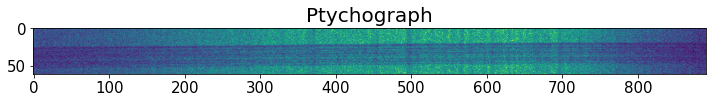

In [755]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(data_st[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.show()
# plt.savefig('figures/ptycho.pdf')

In [756]:
#---------------------------
# Intialise
#---------------------------
data_st = np.ascontiguousarray(data_st)
mask_st = np.ones((data_st.shape[1], data_st.shape[2]), dtype=bool)
w_st = st.make_whitefield(data_st, mask_st)
df_st = 0.000085

# generate pixel map
u_st, dij_pix, res = st.generate_pixel_map(w_st.shape, dij, basis_st,
                                           x_ps_st, y_ps_st, z_st,
                                           df_st, verbose=False)
dss, dfs = res['dss'], res['dfs']

# make reference image
O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st, subpixel=True)

building object map: 100%|██████████| 61/61 [00:00<00:00, 3155.95it/s]

Making the whitefield


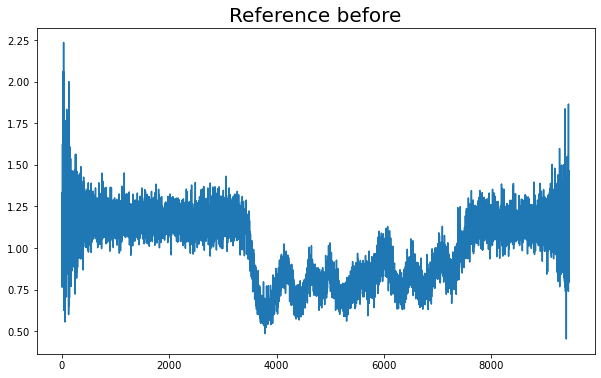

In [757]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(O[0])
ax.set_title('Reference before', fontsize=20)
plt.show()

In [758]:
#---------------------------
# Main loop
#---------------------------
es = []
for i in range(10):

    # calculate errors
    error_total = st.calc_error(data_st, mask_st, w_st, dij_pix, O, u_st,
                                n0, m0, subpixel=True, verbose=False)[0]

    # store total error
    es.append(error_total)

    # update pixel map
    u_st = st.update_pixel_map(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix,
                               search_window=[1, 400], subpixel=True,
                               fill_bad_pix=True, integrate=False,
                               quadratic_refinement=True, verbose=False)[0]

    # make reference image
    O, n0, m0 = st.make_object_map(data_st, mask_st, w_st, dij_pix, u_st,
                                   subpixel=True, verbose=False)
    
    # update translations
    dij_pix = st.update_translations(data_st, mask_st, w_st, O, u_st, n0, m0, dij_pix)[0]

updating object map and translations: 2.27e+01:   0%|          | 0/100 [00:00<?, ?it/s]


In [759]:
def ab_model(pix, coeff):
    return coeff[0] * (pix - coeff[2])**2 + coeff[1]

def ab_errors(coeff, data):
    return (ab_model(data[:, 0], coeff) - data[:, 1])

In [760]:
ur_st = np.array([0, data_st.shape[-1]])
u_pix = -(u_st[1, 0] - np.arange(roi_st[3] - roi_st[2]))
u = u_pix * x_ps_st / z_st
ph_st = np.cumsum(u) * x_ps_st * df_st / z_st * 2 * np.pi / wl_st
# pix_st = gaussian_filter(u_st[1, 0], 25)
pix_st = np.arange(roi_st[3] - roi_st[2])[ur_st[0]:ur_st[1]]
x_st, th_st = pix_st * x_ps_st, pix_st * x_ps_st / z_st

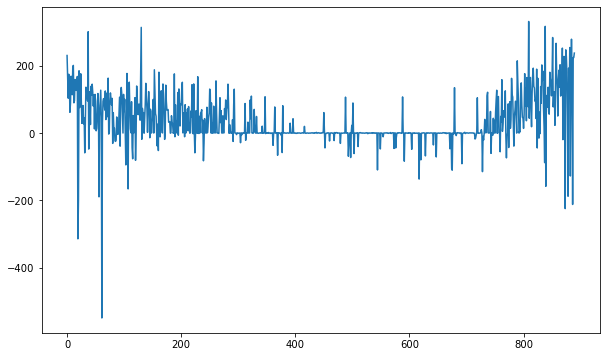

In [761]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(pix_st, u_pix)
plt.show()

In [762]:
fit_data = np.stack((pix_st, gaussian_filter(u_pix, 10)), axis=1)
pix0 = pix_st[np.argmin(fit_data[:, 1])]
res_u = least_squares(ab_errors, np.array([0, 0, pix0]), args=(fit_data,), xtol=1e-14, ftol=1e-14,
                      bounds=([-np.inf, -np.inf, pix0 - 400], [np.inf, np.inf, pix0 + 400]),
                      loss='cauchy', f_scale=1)
fit_u = np.array([res_u.x[0] * z_st / x_ps_st,
                  res_u.x[1] * x_ps_st / z_st,
                  res_u.x[2] * x_ps_st / z_st])
fit_ph = np.array([fit_u[0] * 2 * np.pi / wl_st * df_st / 3,
                   fit_u[1] * 2 * np.pi / wl_st * df_st,
                   ph_st[np.searchsorted(th_st, fit_u[2])], fit_u[2]])

In [763]:
r_sq = 1 - np.sum(ab_errors(res_u.x, fit_data)**2) / np.sum((fit_data[:, 1] - fit_data[:, 1].mean())**2)
r_sq, -fit_ph[0] * 1e-9

(0.19203149797208052, -0.025511045479269554)

In [764]:
u_dict[key] = u
o_dict[key] = O
th_dict[key] = th_st
ph_dict[key] = ph_st
uf_dict[key] = fit_u
phf_dict[key] = fit_ph
data_dict[key] = data_st
r_dict[key] = r_sq

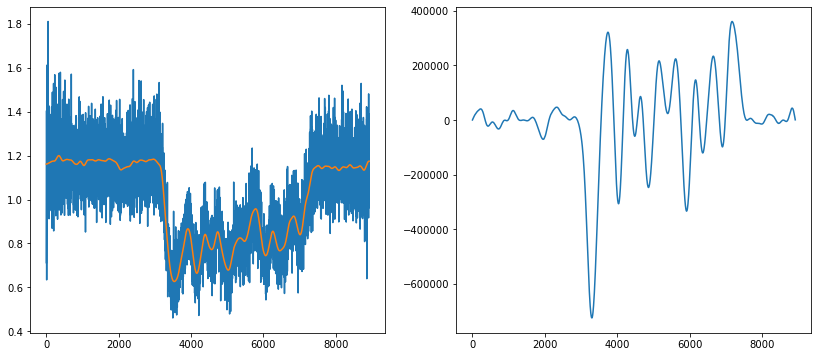

In [765]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(O[0, 500:-500])
axes[0].plot(gaussian_filter(O[0, 500:-500], 50))
axes[1].plot(np.gradient(gaussian_filter(O[0, 500:-500], 100), dx))
plt.show()

In [766]:
dx = np.sqrt((basis_st**2).sum(axis=-1))[0, 0] / z_st * df_st
for key in o_dict:
    do_std = np.std(np.gradient(gaussian_filter(o_dict[key][0, 500:-500], 50), dx)) * 1e-6
    std = np.mean((o_dict[key][0, 500:-500] - gaussian_filter(o_dict[key][0, 500:-500], 50))**2)
    print(key, do_std)
    print(key, std)

1511 0.23612790577533346
1511 0.0037540523687783355
1512 0.23936378109681172
1512 0.005504037822617589
1513 0.2364777552599254
1513 0.009530208002913713


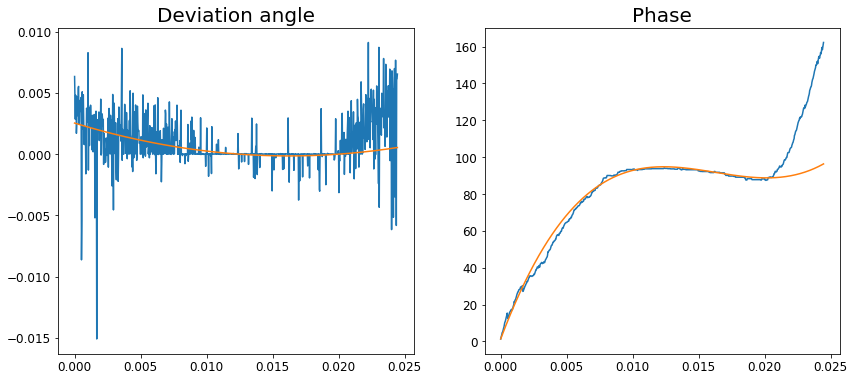

In [767]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(th_st, u)
axes[0].plot(th_st, ab_model(th_st, fit_u))
axes[0].set_title('Deviation angle', fontsize=20)
axes[1].plot(th_st, ph_st)
axes[1].plot(th_st, ph_model(th_st, fit_ph))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()
# plt.savefig('figures/st_results.pdf')

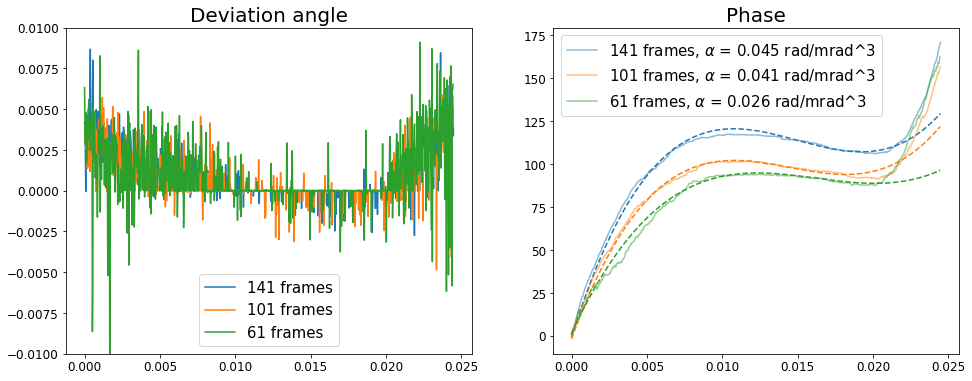

In [787]:
import matplotlib.colors as mcolors

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for key, color in zip(u_dict, mcolors.TABLEAU_COLORS):
    axes[0].plot(th_dict[key], u_dict[key],
                 label='{:d} frames'.format(data_dict[key].shape[0]),
                 color=color)
    axes[0].set_title('Deviation angle', fontsize=20)
    axes[1].plot(th_dict[key], ph_dict[key],
                 label='{:d} frames, '.format(data_dict[key].shape[0]) +
                 r'$\alpha$' + ' = {:.3f} rad/mrad^3'.format(phf_dict[key][0] * 1e-9),
                 color=color, alpha=0.5)
    axes[1].plot(th_dict[key], ph_model(th_dict[key], phf_dict[key]), color=color, linestyle='dashed')
    axes[1].set_title('Phase', fontsize=20)
axes[0].set_ylim(-0.01, 0.01)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=15)
plt.show()
# plt.savefig('figures/exp_results.pdf')

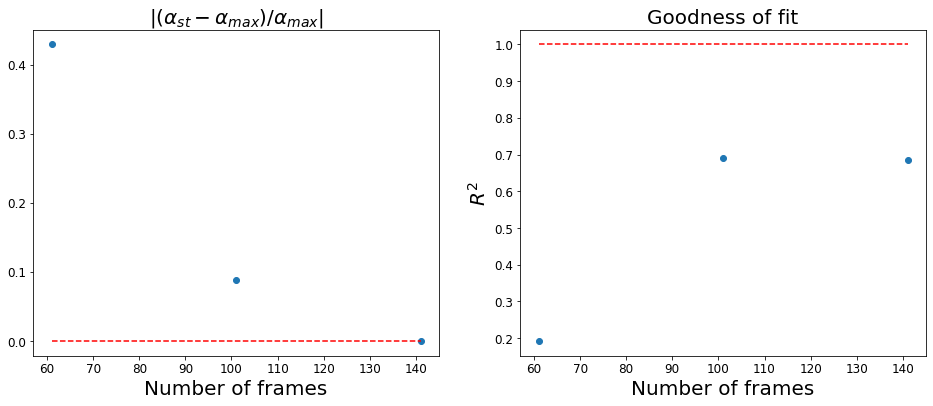

In [788]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
alpha_arr = np.array([ph_fit[0] * 1e-9 for ph_fit in phf_dict.values()])
r_arr = np.array(list(r_dict.values()))
da_arr = np.abs(alpha_arr - alpha_arr.max()) / alpha_arr.max()
nf_arr = np.array(list(nf_dict.values()))
axes[0].scatter(nf_arr, da_arr)
axes[0].plot(np.linspace(nf_arr.min(), nf_arr.max()), np.zeros(50), 'r--')
axes[0].set_title(r'$|(\alpha_{st} - \alpha_{max}) / \alpha_{max}$|', fontsize=20)
axes[1].scatter(nf_arr, r_arr)
axes[1].plot(np.linspace(nf_arr.min(), nf_arr.max()), np.ones(50), 'r--')
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Number of frames', fontsize=20)
plt.show()
# plt.savefig('figures/exp_fits.pdf')

# Wavefront analysis

In [160]:
scan_dir = 'results/n_frames_p7e7'
scan = {}
for path in os.listdir(scan_dir):
    if os.path.isdir(os.path.join(scan_dir, path)):
        print(path)
        data_dir = os.path.join(scan_dir, path)
        params = st_sim.STSim.import_ini(os.path.join(data_dir, 'parameters.ini'))
        fx = params['ap_x'] / 2 / params['focus']
        z_bar = params['defoc'] * params['det_dist'] / (params['defoc'] + params['det_dist'])
        th_max = abs(params['wl'] / 2 / np.pi * params['alpha'] * 3e9 * fx**2 / (params['defoc'] + z_bar))
        sw_max = max(int(2 * th_max / params['pix_size'] * params['det_dist']), 10)
        res = speckle_tracking(os.path.join(data_dir, 'data.cxi'), max_iter=10, search_window=(1, sw_max))
        scan[path] = res
        scan[path].update(params)
        
with open(os.path.join(scan_dir, 'st_results.d'), 'wb') as file:
    pickle.dump(scan, file)

building object map: 100%|██████████| 396/396 [00:00<00:00, 2098.07it/s]

n_frames_396



calculating errors:   0%|          | 0/242 [00:00<?, ?it/s]

n_frames_242


building object map:  39%|███▉      | 164/422 [00:00<00:00, 1638.62it/s]

n_frames_422


calculating errors:   0%|          | 0/216 [00:00<?, ?it/s]

n_frames_216


building object map:  37%|███▋      | 165/448 [00:00<00:00, 1642.15it/s]

n_frames_448


calculating errors:   0%|          | 0/267 [00:00<?, ?it/s]

n_frames_267


calculating errors:   0%|          | 0/293 [00:00<?, ?it/s]

n_frames_293


building object map:  45%|████▍     | 166/371 [00:00<00:00, 1655.12it/s]

n_frames_371


building object map:   0%|          | 0/138 [00:00<?, ?it/s]

n_frames_138


calculating errors:   0%|          | 0/190 [00:00<?, ?it/s]

n_frames_190


calculating errors: 100%|██████████| 164/164 [00:00<00:00, 2053.70it/s]

n_frames_164



building object map:  32%|███▏      | 159/500 [00:00<00:00, 1581.03it/s]

n_frames_500


updating pixel map: 3.79e-01: 100%|██████████| 10/10 [00:00<00:00, 170.23it/s]

n_frames_35



updating pixel map: 4.70e-01:   0%|          | 0/10 [00:00<?, ?it/s]

n_frames_61


building object map:  33%|███▎      | 158/474 [00:00<00:00, 1577.54it/s]

n_frames_474


building object map: 100%|██████████| 87/87 [00:00<00:00, 1539.25it/s]

n_frames_87



updating object map and translations:   0%|          | 0/100 [00:00<?, ?it/s]

n_frames_10


building object map:  47%|████▋     | 161/345 [00:00<00:00, 1603.63it/s]

n_frames_345


building object map:  51%|█████     | 162/319 [00:00<00:00, 1611.46it/s]

n_frames_319


building object map:   0%|          | 0/113 [00:00<?, ?it/s]

n_frames_113


updating object map and translations: 6.53e+01:   0%|          | 0/100 [00:00<?, ?it/s]


In [5]:
with open('results/defoc/st_results.d', 'rb') as file:
    scan = pickle.load(file)
scan_z1 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['defoc'])}
z1_arr = np.array([scan['defoc'] for scan in scan_z1.values()])
err_arr = np.array([scan['st_err'][-1] for scan in scan_z1.values()])
r_arr = np.array([scan['r_sq'] for scan in scan_z1.values()])
da_arr = np.array([scan['dalpha'] for scan in scan_z1.values()])
alpha_arr = np.array([scan['fit_ph'][0] for scan in scan_z1.values()])

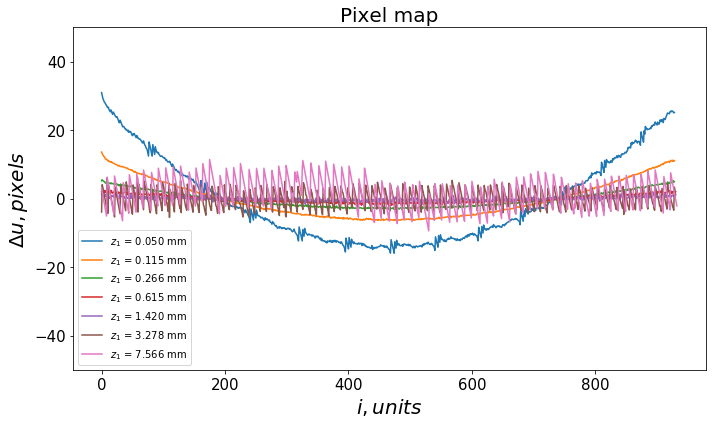

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
for scan in list(scan_z1.keys())[::3]:
    ax.plot(scan_z1[scan]['pixel_map'] , label=r'$z_1$ = {:.3f} mm'.format(scan_z1[scan]['defoc'] * 1e-3))
ax.set_title('Pixel map', fontsize=20)
ax.set_ylabel('$\Delta u, pixels$', fontsize=20)
ax.set_xlabel('$i, units$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(-50, 50)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('figures/defoc/pixel_map.pdf')

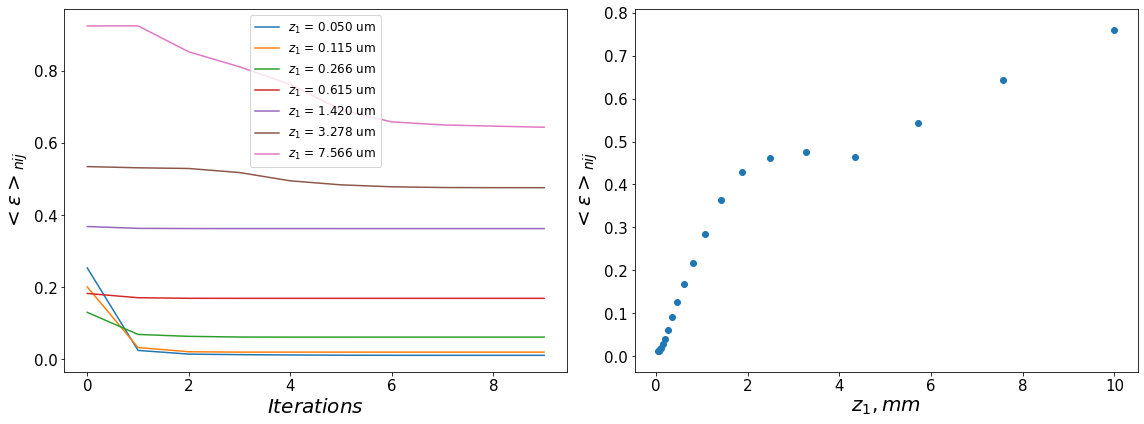

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for scan in list(scan_z1.keys())[::3]:
    axes[0].plot(scan_z1[scan]['st_err'], label=r'$z_1$ = {:.3f} um'.format(scan_z1[scan]['defoc'] * 1e-3))
axes[0].legend(fontsize=12)
axes[0].set_xlabel(r'$Iterations$', fontsize=20)
axes[1].scatter(z1_arr * 1e-3, err_arr)
axes[1].set_xlabel(r'$z_1, mm$', fontsize=20)
for ax in axes:
    ax.set_ylabel(r'$<\varepsilon>_{nij}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/defoc/st_errors.pdf')

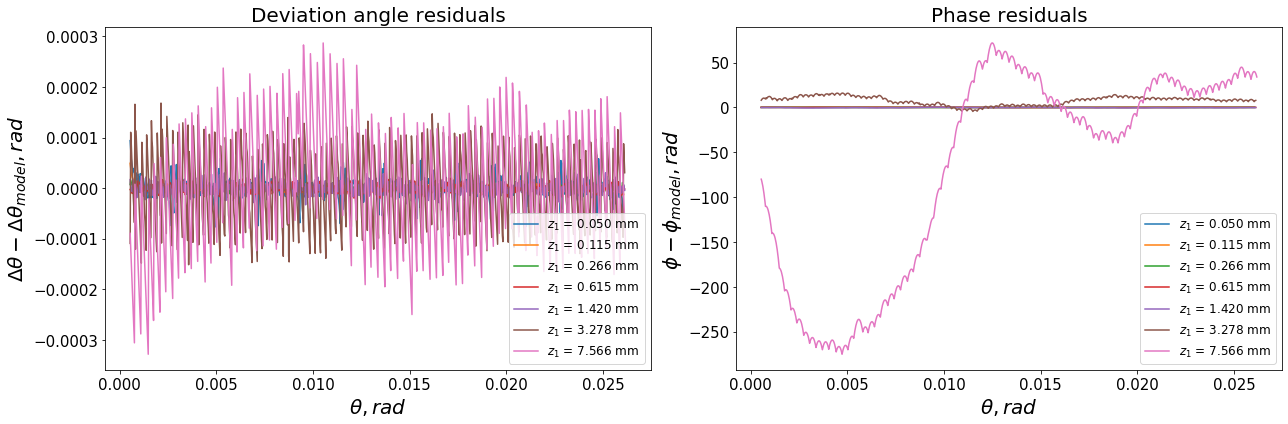

In [8]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for scan in list(scan_z1.keys())[::3]:
    axes[0].plot(scan_z1[scan]['theta'],
                 scan_z1[scan]['dev_angle'] - ab_model(scan_z1[scan]['theta'], scan_z1[scan]['fit_u']),
                 label=r'$z_1$ = {:.3f} mm'.format(scan_z1[scan]['defoc'] * 1e-3))
    axes[0].set_title('Deviation angle residuals', fontsize=20)
    axes[0].set_ylabel(r'$\Delta \theta - \Delta \theta_{model}, rad$', fontsize=20)
    axes[1].plot(scan_z1[scan]['theta'],
                 scan_z1[scan]['phase'] - ph_model(scan_z1[scan]['theta'], scan_z1[scan]['fit_ph']),
                 label=r'$z_1$ = {:.3f} mm'.format(scan_z1[scan]['defoc'] * 1e-3))
    axes[1].set_title('Phase residuals', fontsize=20)
    axes[1].set_ylabel(r'$\phi - \phi_{model}, rad$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$\theta, rad$', fontsize=20)
    ax
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/defoc/fit_residuals.pdf')

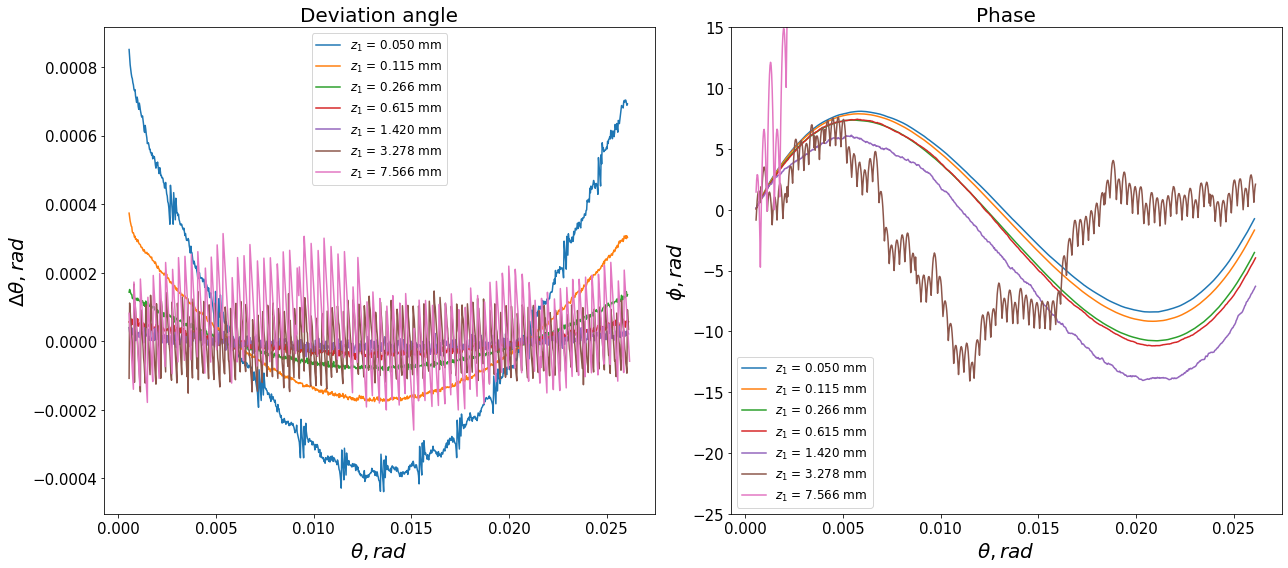

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for scan in list(scan_z1.keys())[::3]:
    axes[0].plot(scan_z1[scan]['theta'], scan_z1[scan]['dev_angle'],
                 label=r'$z_1$ = {:.3f} mm'.format(scan_z1[scan]['defoc'] * 1e-3))
    axes[0].set_title('Deviation angle', fontsize=20)
    axes[0].set_ylabel(r'$\Delta \theta, rad$', fontsize=20)
    axes[1].plot(scan_z1[scan]['theta'], scan_z1[scan]['phase'],
                 label=r'$z_1$ = {:.3f} mm'.format(scan_z1[scan]['defoc'] * 1e-3))
    axes[1].set_title('Phase', fontsize=20)
    axes[1].set_ylabel(r'$\phi, rad$', fontsize=20)
    axes[1].set_ylim(-25, 15)
for ax in axes:
    ax.set_xlabel(r'$\theta, rad$', fontsize=20)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/defoc/st_results.pdf')

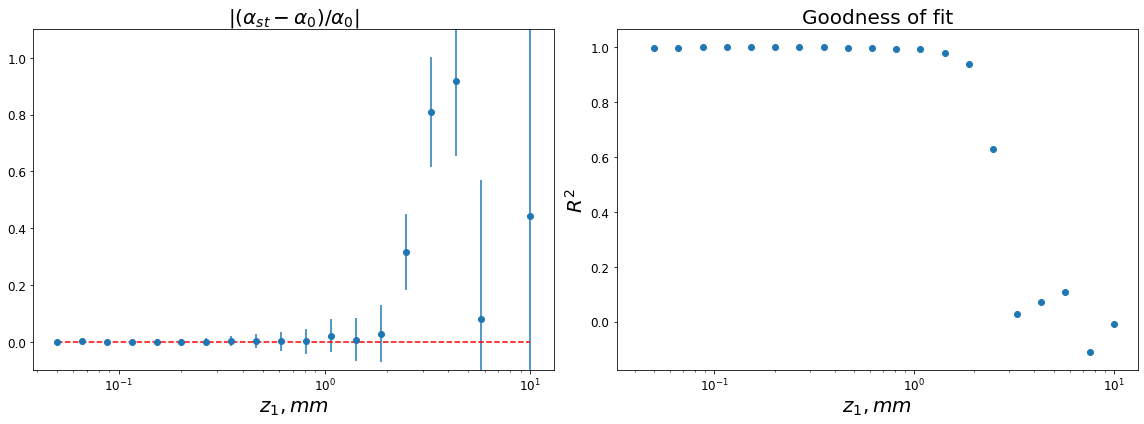

In [10]:
%matplotlib inline
alpha0 = next(iter(scan_z1.values()))['alpha'] * 1e9
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].errorbar(z1_arr * 1e-3, np.abs((alpha0 + alpha_arr) / alpha0), yerr=np.abs(da_arr / alpha0), fmt='o')
axes[0].plot(z1_arr * 1e-3, np.zeros(z1_arr.size), linestyle='dashed', color='red')
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_title('Abberations coefficient', fontsize=20)
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[1].scatter(z1_arr * 1e-3, r_arr)
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel(r'$z_1, mm$', fontsize=20)
    ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/defoc/fit_errors.pdf')

In [11]:
with open('results/p0_t65/st_results.d', 'rb') as file:
    scan = pickle.load(file)
scan_p0 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['p0'])}
ppix_arr = np.array([scan['ppix'] for scan in scan_p0.values()])
err_arr = np.array([scan['st_err'][-1] for scan in scan_p0.values()])
r_arr = np.array([scan['r_sq'] for scan in scan_p0.values()])
da_arr = np.array([scan['dalpha'] for scan in scan_p0.values()])
alpha_arr = np.array([scan['fit_ph'][0] for scan in scan_p0.values()])

In [12]:
dir_path = 'results/p0_t65'
path = os.path.join(dir_path, os.listdir(dir_path)[0])
p0_params = st_sim.STSim.import_ini(os.path.join(path, 'parameters.ini'))
snr_arr = snr_exp(ppix_arr, p0_params['attenuation'], p0_params['bar_size'], p0_params['bar_sigma'])

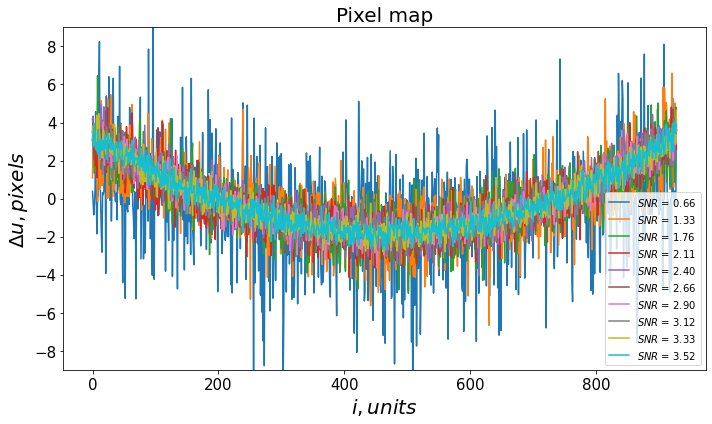

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
for snr, scan in list(zip(snr_arr, scan_p0.keys()))[::2]:
    ax.plot(scan_p0[scan]['pixel_map'] ,
            label=r'$SNR$' + ' = {:.2f}'.format(snr))
ax.set_title('Pixel map', fontsize=20)
ax.set_ylabel('$\Delta u, pixels$', fontsize=20)
ax.set_xlabel('$i, units$', fontsize=20)
ax.set_ylim(-9, 9)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('figures/p0/pixel_map.pdf')

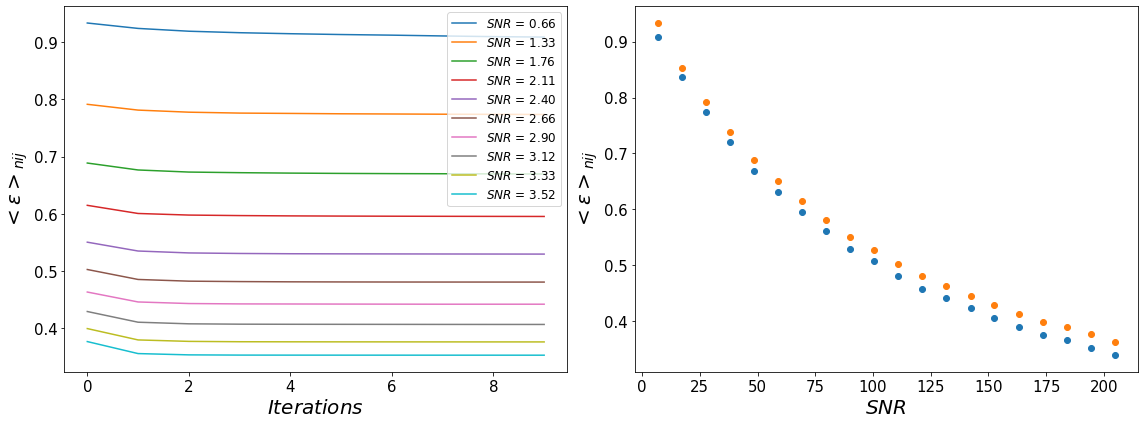

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for snr, scan in list(zip(snr_arr, scan_p0.keys()))[::2]:
    axes[0].plot(scan_p0[scan]['st_err'],
                 label=r'$SNR$' + ' = {:.2f}'.format(snr))
axes[0].legend(fontsize=12)
axes[0].set_xlabel(r'$Iterations$', fontsize=20)
axes[1].scatter(ppix_arr, err_arr)
axes[1].scatter(ppix_arr, np.array([scan['st_err'][0] for scan in scan_p0.values()]))
axes[1].set_xlabel(r'$SNR$', fontsize=20)
for ax in axes:
    ax.set_ylabel(r'$<\varepsilon>_{nij}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/p0/st_errors.pdf')

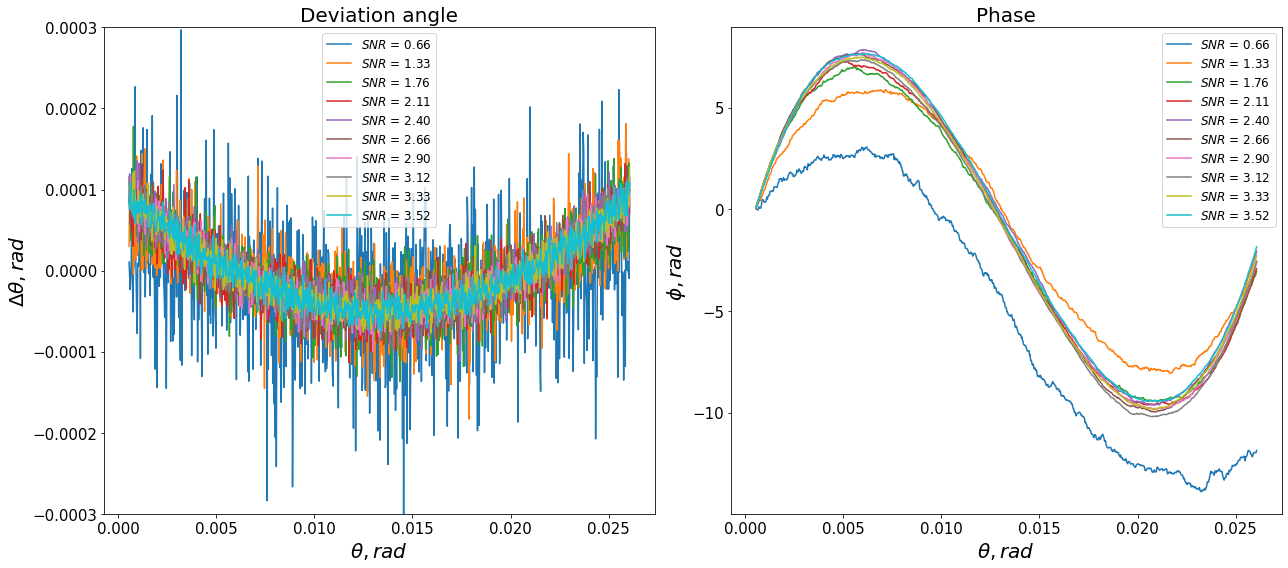

In [17]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for snr, scan in list(zip(snr_arr, scan_p0.keys()))[::2]:
    axes[0].plot(scan_p0[scan]['theta'], scan_p0[scan]['dev_angle'],
                 label=r'$SNR$' + ' = {:.2f}'.format(snr))
    axes[0].set_title('Deviation angle', fontsize=20)
    axes[0].set_ylabel(r'$\Delta \theta, rad$', fontsize=20)
    axes[0].set_ylim(-0.0003, 0.0003)
    axes[1].plot(scan_p0[scan]['theta'], scan_p0[scan]['phase'],
                 label=r'$SNR$' + ' = {:.2f}'.format(snr))
    axes[1].set_title('Phase', fontsize=20)
    axes[1].set_ylabel(r'$\phi, rad$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$\theta, rad$', fontsize=20)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/p0/st_results.pdf')

In [126]:
with open('results/p0_t65/st_results.d', 'rb') as file:
    scan = pickle.load(file)
    scan_p0_t65 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['p0'])}
    dir_path = 'results/p0_t65'
    path = os.path.join(dir_path, os.listdir(dir_path)[0])
    p0_params = st_sim.STSim.import_ini(os.path.join(path, 'parameters.ini'))
    ppix_arr = np.array([scan['ppix'] for scan in scan_p0_t65.values()])
    r_t65 = np.array([scan['r_sq'] for scan in scan_p0_t65.values()])
    da_t65 = np.array([scan['dalpha'] for scan in scan_p0_t65.values()])
    alpha_t65 = np.array([scan['fit_ph'][0] for scan in scan_p0_t65.values()])
    snr_t65 = snr_exp(ppix_arr, p0_params['attenuation'], p0_params['bar_size'], p0_params['bar_sigma'])
with open('results/p0_t30/st_results.d', 'rb') as file:
    scan = pickle.load(file)
    scan_p0_t30 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['p0'])}
    dir_path = 'results/p0_t30'
    path = os.path.join(dir_path, os.listdir(dir_path)[0])
    p0_params = st_sim.STSim.import_ini(os.path.join(path, 'parameters.ini'))
    ppix_arr = np.array([scan['ppix'] for scan in scan_p0_t30.values()])
    r_t30 = np.array([scan['r_sq'] for scan in scan_p0_t30.values()])
    da_t30 = np.array([scan['dalpha'] for scan in scan_p0_t30.values()])
    alpha_t30 = np.array([scan['fit_ph'][0] for scan in scan_p0_t30.values()])
    snr_t30 = snr_exp(ppix_arr, p0_params['attenuation'], p0_params['bar_size'], p0_params['bar_sigma'])

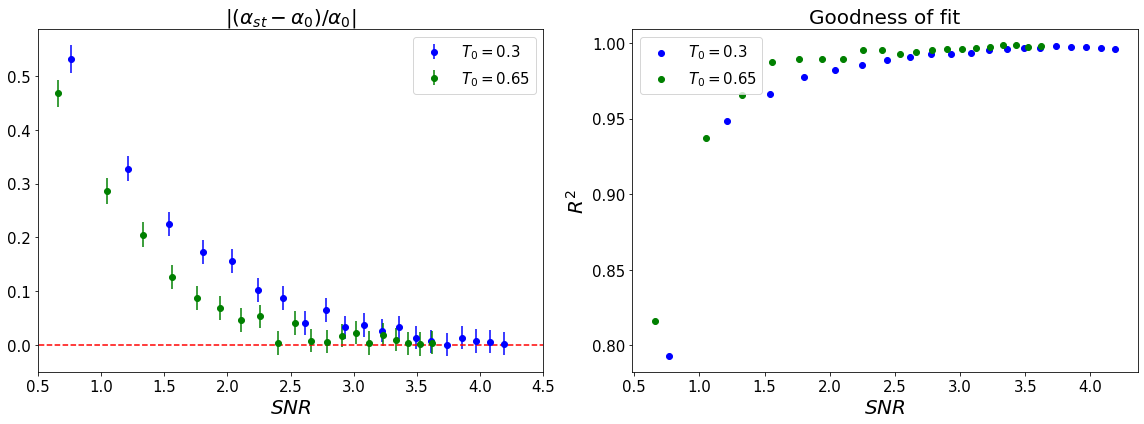

In [143]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
alpha0 = next(iter(scan_p0_t30.values()))['alpha'] * 1e9
axes[0].errorbar(snr_t30, np.abs((alpha0 + alpha_t30) / alpha0), yerr=np.abs(da_t30 / alpha0),
                 fmt='o', color='blue', label=r'$T_0 = 0.3$')
axes[0].errorbar(snr_t65, np.abs((alpha0 + alpha_t65) / alpha0), yerr=np.abs(da_t65 / alpha0),
                 fmt='o', color='green', label=r'$T_0 = 0.65$')
axes[0].plot(np.linspace(0, 5), np.zeros(50), linestyle='dashed', color='red')
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[0].set_xlim(0.5, 4.5)
axes[1].scatter(snr_t30, r_t30, color='blue', label=r'$T_0 = 0.3$')
axes[1].scatter(snr_t65, r_t65, color='green', label=r'$T_0 = 0.65$')
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$SNR$', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/p0_snr_scan.pdf')

In [171]:
with open('results/n_frames_p3e7/st_results.d', 'rb') as file:
    scan = pickle.load(file)
    scan_nf_p3e7 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['n_frames'])}
    dir_path = 'results/n_frames_p3e7'
    path = os.path.join(dir_path, os.listdir(dir_path)[0])
    nf_params = st_sim.STSim.import_ini(os.path.join(path, 'parameters.ini'))
    nf_arr = np.array([scan['n_frames'] for scan in scan_nf_p3e7.values()])
    ppix_arr = np.array([scan['ppix'] for scan in scan_nf_p3e7.values()])
    r_p3e7 = np.array([scan['r_sq'] for scan in scan_nf_p3e7.values()])
    da_p3e7 = np.array([scan['dalpha'] for scan in scan_nf_p3e7.values()])
    alpha_p3e7 = np.array([scan['fit_ph'][0] for scan in scan_nf_p3e7.values()])
    snr_p3e7 = snr_exp(ppix_arr, nf_params['attenuation'], nf_params['bar_size'], nf_params['bar_sigma'])
with open('results/n_frames_p5e7/st_results.d', 'rb') as file:
    scan = pickle.load(file)
    scan_nf_p5e7 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['n_frames'])}
    ppix_arr = np.array([scan['ppix'] for scan in scan_nf_p5e7.values()])
    r_p5e7 = np.array([scan['r_sq'] for scan in scan_nf_p5e7.values()])
    da_p5e7 = np.array([scan['dalpha'] for scan in scan_nf_p5e7.values()])
    alpha_p5e7 = np.array([scan['fit_ph'][0] for scan in scan_nf_p5e7.values()])
    snr_p5e7 = snr_exp(ppix_arr, nf_params['attenuation'], nf_params['bar_size'], nf_params['bar_sigma'])
with open('results/n_frames_p7e7/st_results.d', 'rb') as file:
    scan = pickle.load(file)
    scan_nf_p7e7 = {k: v for k, v in sorted(scan.items(), key=lambda item: item[1]['n_frames'])}
    ppix_arr = np.array([scan['ppix'] for scan in scan_nf_p7e7.values()])
    r_p7e7 = np.array([scan['r_sq'] for scan in scan_nf_p7e7.values()])
    da_p7e7 = np.array([scan['dalpha'] for scan in scan_nf_p7e7.values()])
    alpha_p7e7 = np.array([scan['fit_ph'][0] for scan in scan_nf_p7e7.values()])
    snr_p7e7 = snr_exp(ppix_arr, nf_params['attenuation'], nf_params['bar_size'], nf_params['bar_sigma'])

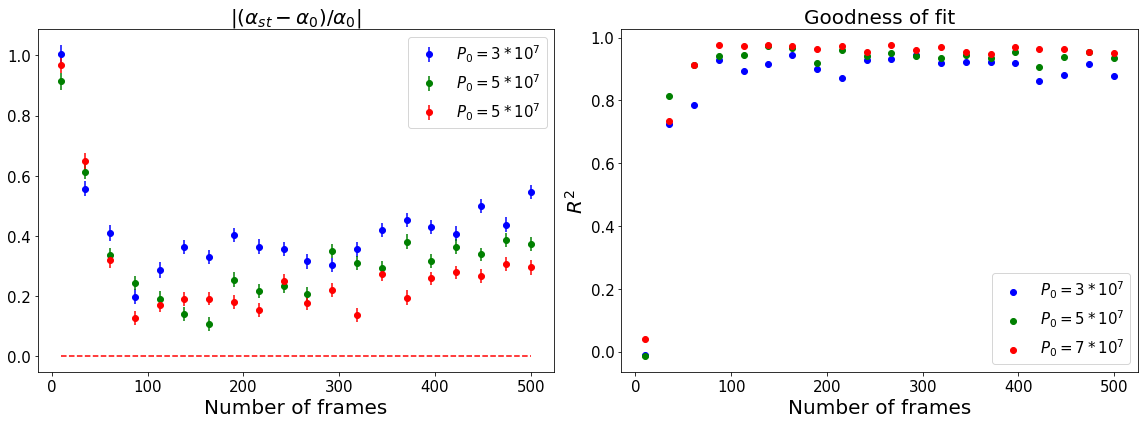

In [177]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
alpha0 = next(iter(scan_p0_t30.values()))['alpha'] * 1e9
axes[0].errorbar(nf_arr, np.abs((alpha0 + alpha_p3e7) / alpha0), yerr=np.abs(da_p3e7 / alpha0),
                 fmt='o', color='blue', label=r'$P_0 = 3*10^7$')
axes[0].errorbar(nf_arr, np.abs((alpha0 + alpha_p5e7) / alpha0), yerr=np.abs(da_p5e7 / alpha0),
                 fmt='o', color='green', label=r'$P_0 = 5*10^7$')
axes[0].errorbar(nf_arr, np.abs((alpha0 + alpha_p7e7) / alpha0), yerr=np.abs(da_p7e7 / alpha0),
                 fmt='o', color='red', label=r'$P_0 = 5*10^7$')
axes[0].plot(np.linspace(10, 500), np.zeros(50), linestyle='dashed', color='red')
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[1].scatter(nf_arr, r_p3e7, color='blue', label=r'$P_0 = 3*10^7$')
axes[1].scatter(nf_arr, r_p5e7, color='green', label=r'$P_0 = 5*10^7$')
axes[1].scatter(nf_arr, r_p7e7, color='red', label=r'$P_0 = 7*10^7$')
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'Number of frames', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
# plt.show()
plt.savefig('figures/nf_scan.pdf')

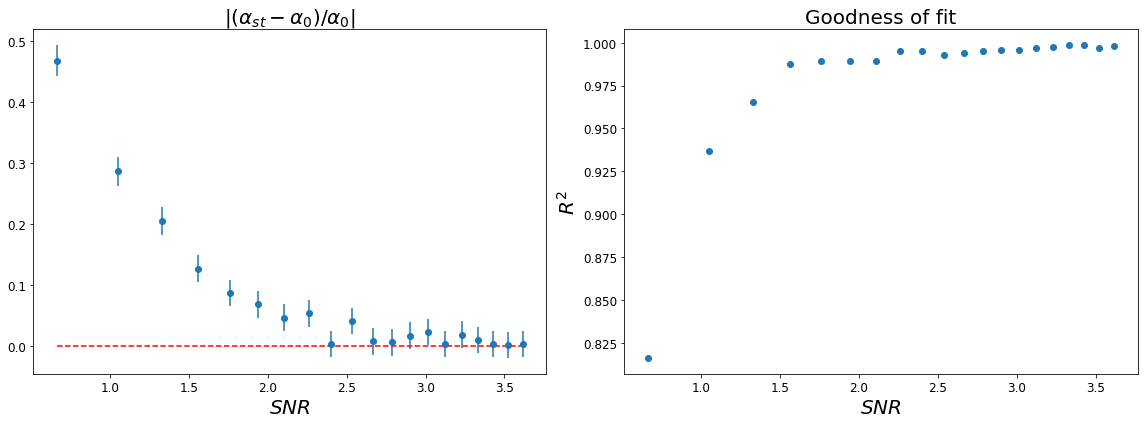

In [18]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
alpha0 = next(iter(scan_p0.values()))['alpha'] * 1e9
axes[0].errorbar(snr_arr, np.abs((alpha0 + alpha_arr) / alpha0),
                 yerr=np.abs(da_arr / alpha0), fmt='o')
axes[0].plot(snr_arr, np.zeros(snr_arr.size), linestyle='dashed', color='red')
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[1].scatter(snr_arr, r_arr)
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$SNR$', fontsize=20)
    ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/p0/fit_errors.pdf')

In [125]:
with open('results/th_s/st_results.d', 'rb') as file:
    scan_ths = pickle.load(file)
scan_ths = {k: v for k, v in sorted(scan_ths.items(), key=lambda item: item[1]['th_s'])}
ths_arr = np.array([scan['th_s'] for scan in scan_ths.values()])
err_arr = np.array([scan['st_err'][-1] for scan in scan_ths.values()])
r_arr = np.array([scan['r_sq'] for scan in scan_ths.values()])
da_arr = np.array([scan['dalpha'] for scan in scan_ths.values()])
alpha_arr = np.array([scan['fit_ph'][0] for scan in scan_ths.values()])
snr_arr = np.array([scan['sigma'] / np.sqrt(scan['ppix']) for scan in scan_ths.values()])
st_scan = next(iter(scan_ths.values()))
alpha0 = st_scan['alpha'] * 1e9
th_f = st_scan['bar_size'] / st_scan['defoc']

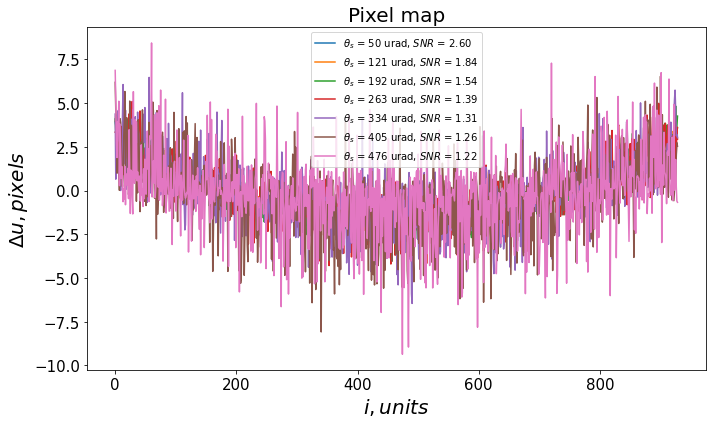

In [127]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
for snr, scan in list(zip(snr_arr, scan_ths.values()))[::3]:
    ax.plot(scan['pixel_map'],
            label=r'$\theta_s$' + ' = {:.0f} urad'.format(scan['th_s'] * 1e6) + 
                  r', $SNR$' + ' = {:.2f}'.format(snr))
ax.set_title('Pixel map', fontsize=20)
ax.set_ylabel('$\Delta u, pixels$', fontsize=20)
ax.set_xlabel('$i, units$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/pixel_map.pdf')

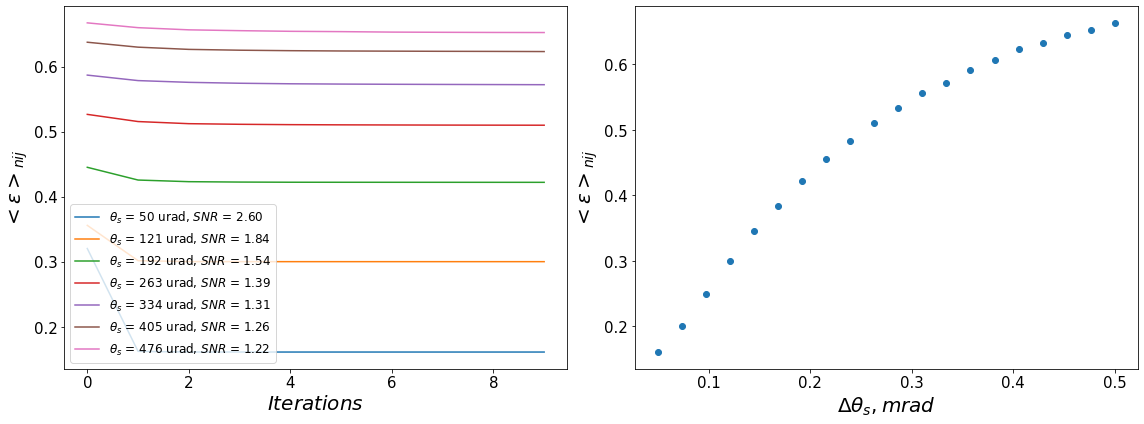

In [128]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for snr, scan in list(zip(snr_arr, scan_ths.values()))[::3]:
    axes[0].plot(scan['st_err'],
                 label=r'$\theta_s$' + ' = {:.0f} urad'.format(scan['th_s'] * 1e6) + 
                 r', $SNR$' + ' = {:.2f}'.format(snr))
axes[0].legend(fontsize=12)
axes[0].set_xlabel(r'$Iterations$', fontsize=20)
axes[1].scatter(ths_arr * 1e3, err_arr)
axes[1].set_xlabel(r'$\Delta\theta_s, mrad$', fontsize=20)
for ax in axes:
    ax.set_ylabel(r'$<\varepsilon>_{nij}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/st_errors.pdf')

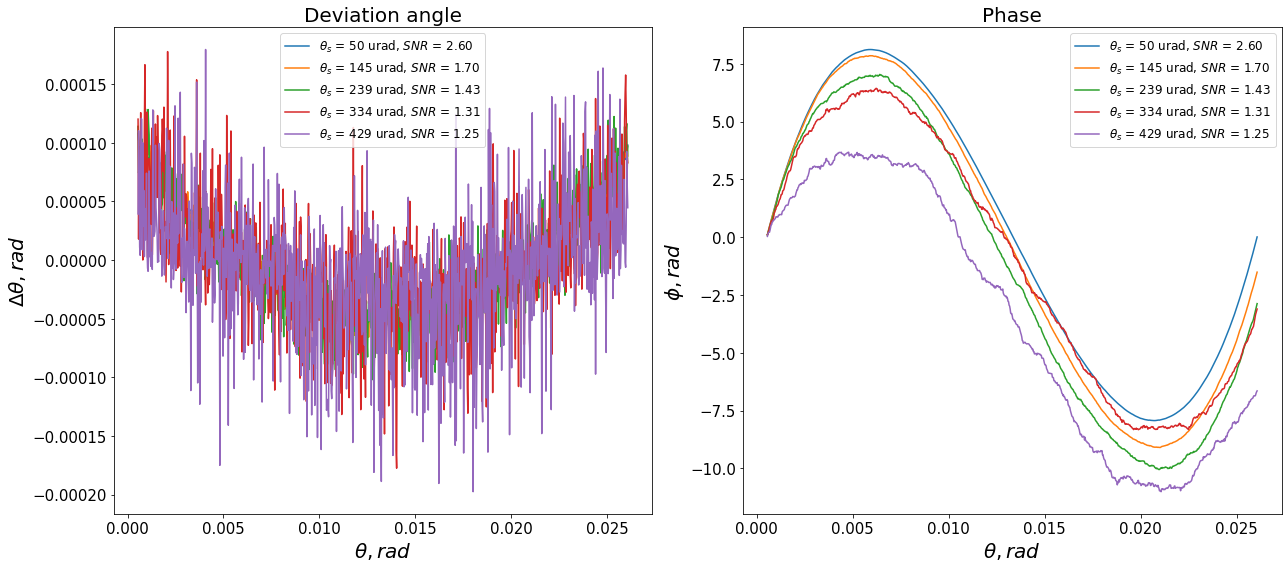

In [129]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for snr, scan in list(zip(snr_arr, scan_ths.values()))[::4]:
    axes[0].plot(scan['theta'], scan['dev_angle'],
                 label=r'$\theta_s$' + ' = {:.0f} urad'.format(scan['th_s'] * 1e6) + 
                 r', $SNR$' + ' = {:.2f}'.format(snr))
    axes[0].set_title('Deviation angle', fontsize=20)
    axes[0].set_ylabel(r'$\Delta \theta, rad$', fontsize=20)
    axes[1].plot(scan['theta'], scan['phase'],
                 label=r'$\theta_s$' + ' = {:.0f} urad'.format(scan['th_s'] * 1e6) + 
                 r', $SNR$' + ' = {:.2f}'.format(snr))
    axes[1].set_title('Phase', fontsize=20)
    axes[1].set_ylabel(r'$\phi, rad$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$\theta, rad$', fontsize=20)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/st_results.pdf')

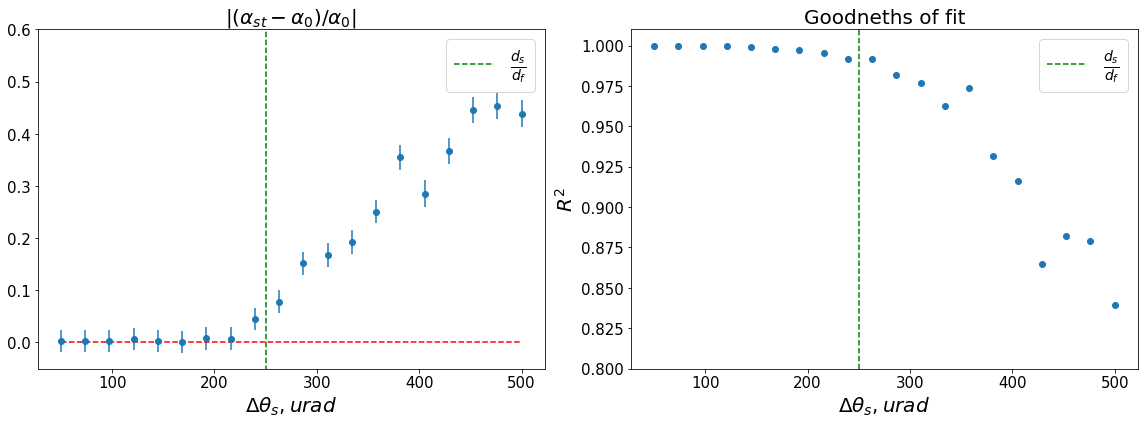

In [155]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].errorbar(ths_arr * 1e6, np.abs((alpha0 + alpha_arr) / alpha0), yerr=np.abs(da_arr / alpha0), fmt='o')
axes[0].plot(ths_arr * 1e6, np.zeros(ths_arr.size), linestyle='dashed', color='red')
axes[0].set_title('Abberations coefficient', fontsize=20)
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[0].set_ylim(-0.05, 0.6)
axes[1].scatter(ths_arr * 1e6, r_arr)
axes[1].set_title('Goodneths of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
axes[1].set_ylim(0.8, 1.01)
for ax in axes:
    ax.plot(th_f * 1e6 * np.ones(50), np.linspace(-0.1, 1.1), linestyle='dashed',
            color='green', label=r'$\frac{d_{s}}{d_f}$')
    ax.set_xlabel(r'$\Delta\theta_s, urad$', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s_fit_errors.pdf')

In [132]:
snr_arr, ths_arr

(array([2.603328 , 2.289792 , 2.0284746, 1.8382641, 1.7049264, 1.6113626,
        1.5359957, 1.4781933, 1.4302644, 1.3912473, 1.3565525, 1.3323227,
        1.3108015, 1.2946992, 1.2759006, 1.2575226, 1.2468343, 1.2338287,
        1.2234458, 1.2162776], dtype=float32),
 array([5.00000000e-05, 7.36842105e-05, 9.73684211e-05, 1.21052632e-04,
        1.44736842e-04, 1.68421053e-04, 1.92105263e-04, 2.15789474e-04,
        2.39473684e-04, 2.63157895e-04, 2.86842105e-04, 3.10526316e-04,
        3.34210526e-04, 3.57894737e-04, 3.81578947e-04, 4.05263158e-04,
        4.28947368e-04, 4.52631579e-04, 4.76315789e-04, 5.00000000e-04]))

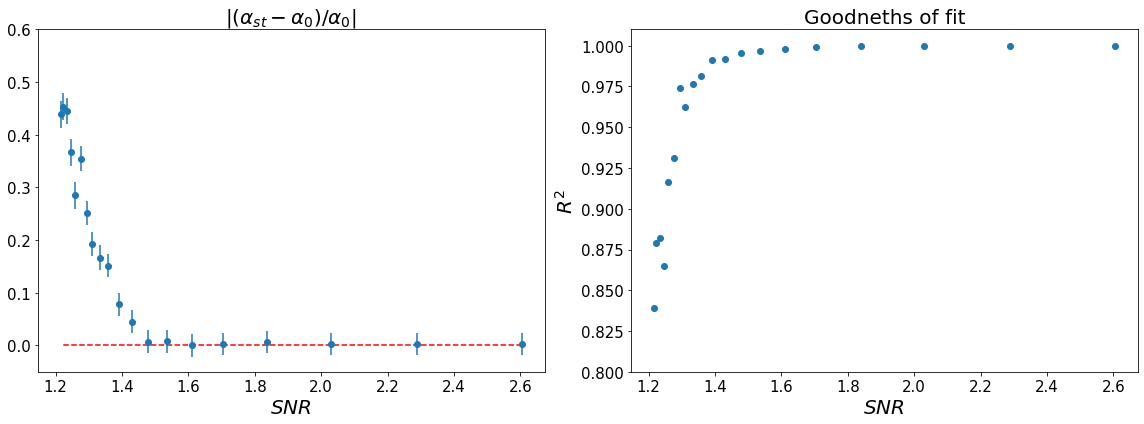

In [131]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].errorbar(snr_arr, np.abs((alpha0 + alpha_arr) / alpha0), yerr=np.abs(da_arr / alpha0), fmt='o')
axes[0].plot(snr_arr, np.zeros(ths_arr.size), linestyle='dashed', color='red')
axes[0].set_title('Abberations coefficient', fontsize=20)
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[0].set_ylim(-0.05, 0.6)
axes[1].scatter(snr_arr, r_arr)
axes[1].set_title('Goodneths of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
axes[1].set_ylim(0.8, 1.01)
for ax in axes:
    ax.set_xlabel(r'$SNR$', fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s_fit_errors.pdf')

In [9]:
with open('results/n_frames_p5e7/st_results.d', 'rb') as file:
    scan_nf = pickle.load(file)
scan_nf = {k: v for k, v in sorted(scan_nf.items(), key=lambda item: item[1]['n_frames'])}
nf_arr = np.array([scan['n_frames'] for scan in scan_nf.values()])
err_arr = np.array([scan['st_err'][-1] for scan in scan_nf.values()])
r_arr = np.array([scan['r_sq'] for scan in scan_nf.values()])
da_arr = np.array([scan['dalpha'] for scan in scan_nf.values()])
alpha_arr = np.array([scan['fit_ph'][0] for scan in scan_nf.values()])

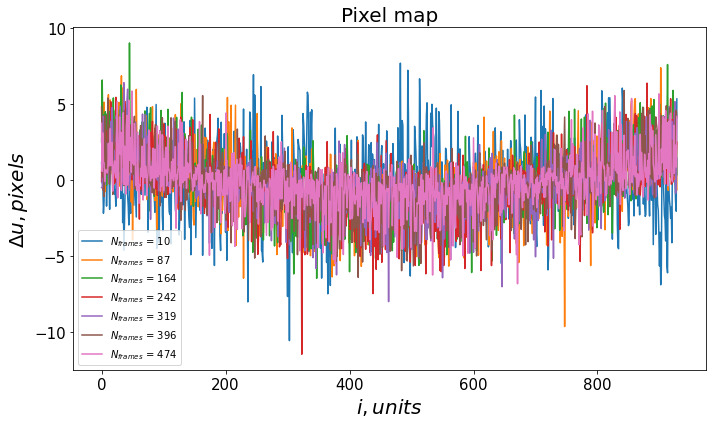

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
for scan in list(scan_nf.keys())[::3]:
    ax.plot(scan_nf[scan]['pixel_map'],
            label=r'$N_{frames}$' + ' = {:d}'.format(scan_nf[scan]['n_frames']))
ax.set_title('Pixel map', fontsize=20)
ax.set_ylabel('$\Delta u, pixels$', fontsize=20)
ax.set_xlabel('$i, units$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/pixel_map.pdf')

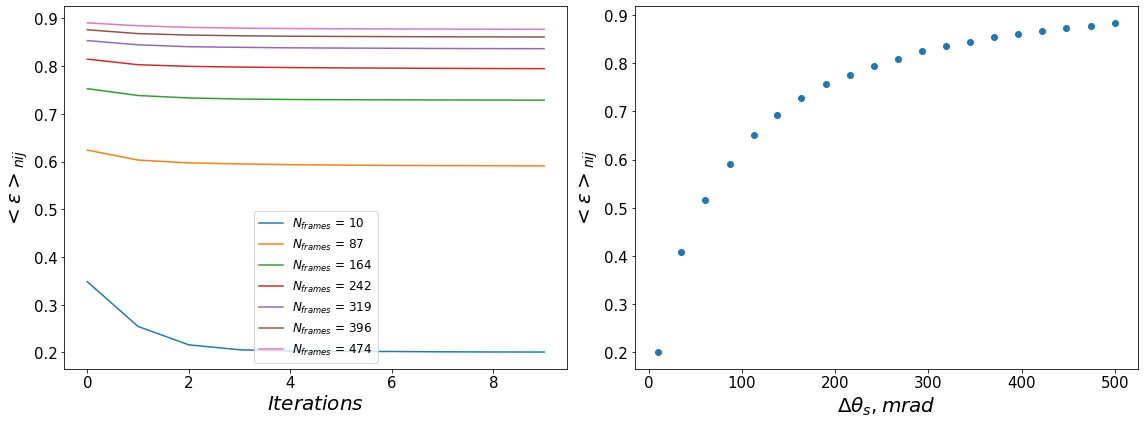

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for scan in list(scan_nf.keys())[::3]:
    axes[0].plot(scan_nf[scan]['st_err'],
                 label=r'$N_{frames}$' + ' = {:d}'.format(scan_nf[scan]['n_frames']))
axes[0].legend(fontsize=12)
axes[0].set_xlabel(r'$Iterations$', fontsize=20)
axes[1].scatter(nf_arr, err_arr)
axes[1].set_xlabel(r'$\Delta\theta_s, mrad$', fontsize=20)
for ax in axes:
    ax.set_ylabel(r'$<\varepsilon>_{nij}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/st_errors.pdf')

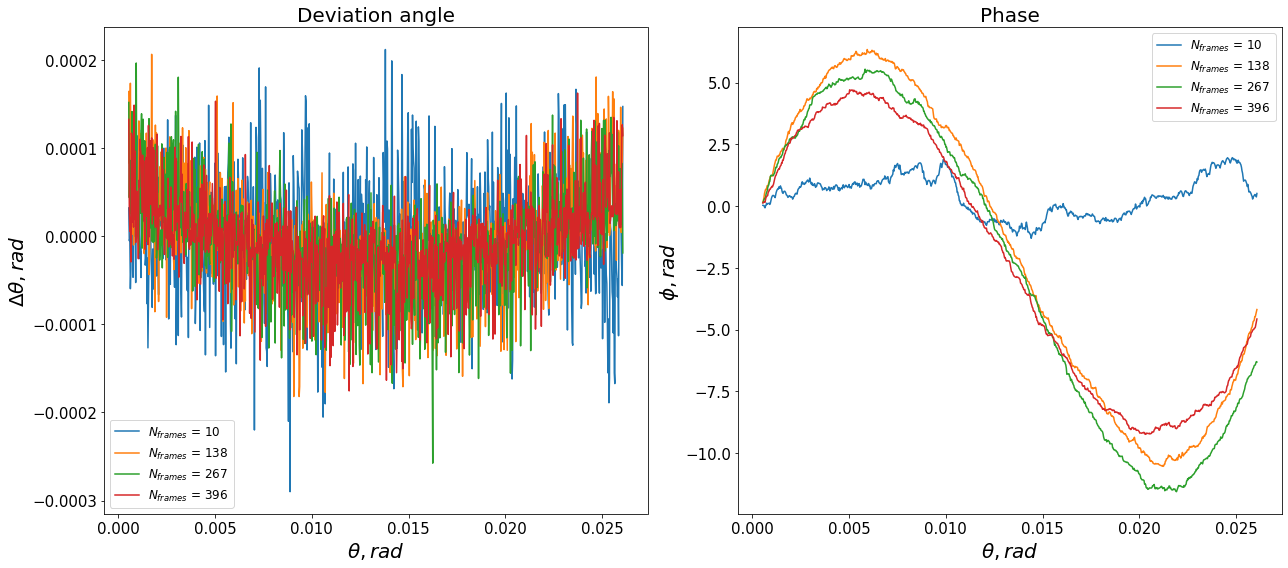

In [12]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for scan in list(scan_nf.keys())[::5]:
    axes[0].plot(scan_nf[scan]['theta'], scan_nf[scan]['dev_angle'],
                 label=r'$N_{frames}$' + ' = {:d}'.format(scan_nf[scan]['n_frames']))
    axes[0].set_title('Deviation angle', fontsize=20)
    axes[0].set_ylabel(r'$\Delta \theta, rad$', fontsize=20)
    axes[1].plot(scan_nf[scan]['theta'], scan_nf[scan]['phase'],
                 label=r'$N_{frames}$' + ' = {:d}'.format(scan_nf[scan]['n_frames']))
    axes[1].set_title('Phase', fontsize=20)
    axes[1].set_ylabel(r'$\phi, rad$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$\theta, rad$', fontsize=20)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/st_results.pdf')

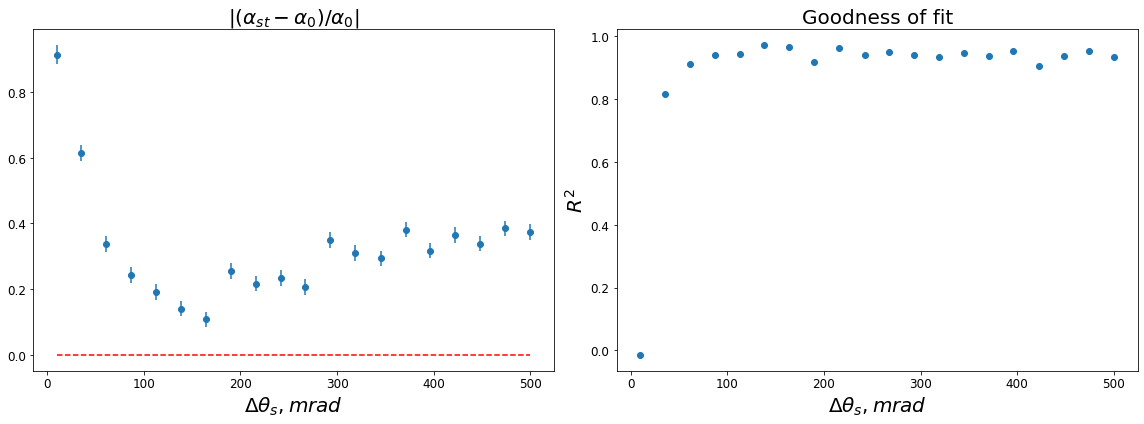

In [13]:
%matplotlib inline
st_scan = next(iter(scan_nf.values()))
alpha0 = st_scan['alpha'] * 1e9
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].errorbar(nf_arr, np.abs((alpha0 + alpha_arr) / alpha0), yerr=np.abs(da_arr / alpha0), fmt='o')
axes[0].plot(nf_arr, np.zeros(nf_arr.size), linestyle='dashed', color='red')
axes[0].set_title('Abberations coefficient', fontsize=20)
axes[0].set_title(r'$|(\alpha_{st} - \alpha_0) / \alpha_0$|', fontsize=20)
axes[1].scatter(nf_arr, r_arr)
axes[1].set_title('Goodness of fit', fontsize=20)
axes[1].set_ylabel(r'$R^2$', fontsize=20)
for ax in axes:
    ax.set_xlabel(r'$\Delta\theta_s, mrad$', fontsize=20)
    ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/th_s/fit_errors.pdf')